# Neural Networks
# Lab 1. Supervised Learning - Classification
# Μέρος 1. UCI dataset
#### Μαρία Ηώς Γλάρου

In [1]:
!pip install --upgrade pip
!pip install --upgrade scikit-learn
!pip install --upgrade numpy
!pip install --upgrade scipy
!pip install --upgrade pandas
!pip install --upgrade seaborn

In [146]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline

# import scikit-learn models
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
# Import classes for preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV
import time
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve


#colors for plots
colors= ["#588c7e", "#96ceb4" ,"#b5e7a0","#86af49", "#e3eaa7"]

In [3]:
#names of features for each sample according to dataset description (in proper order)
feature_names = [
        "COMPACTNESS",
        "CIRCULARITY",
        "DISTANCE CIRCULARITY",
        "RADIUS RATIO",
        "PR.AXIS ASPECT RATIO",
        "MAX.LENGTH ASPECT RATIO",
        "SCATTER RATIO",
        "ELONGATEDNESS",
        "PR.AXIS RECTANGULARITY",
        "MAX.LENGTH RECTANGULARITY",
        "SCALED VARIANCE ALONG MAJOR AXIS",
        "SCALED VARIANCE ALONG MINOR AXIS",
        "SCALED RADIUS OF GYRATION",
        "SKEWNESS ABOUT MINOR AXIS",
        "SKEWNESS ABOUT MAJOR AXIS",
        "KURTOSIS ABOUT MINOR AXIS",
        "KURTOSIS ABOUT MAJOR AXIS",
        "HOLLOWS RATIO"
]

In [188]:
def calc_feature_mean_var(feature):
    """
    :param feature(string): the name of the feature of which we want to calculate the mean and variance
    :return: (float) the mean and variance of values of this feature in train set
    """
    values = list(features_df[feature])
    return np.round(np.mean(values), 2), np.round(np.var(values),2)


# def calc_mean_var_per_feature():"""
#
#     :return: no return value, it prints means, variances for every feature in TRAIN set and the max value of variance
#     """
#     # means_ = {}
#     # variances_ = {}
#     # for feature_ in feature_names:
#     #     mean_, variance_ = calc_feature_mean_var(feature_)
#     #     means_[feature_] = mean_
#     #     variances_[feature_] = variance_
#     variances_ = np.var(X_train, axis=0)
#     means_ = np.mean(X_train, axis = 0)
#     print("| feature                            | mean value | variance |")
#     print("| :--------------------------------: | :--------: | :------: |")
#     for i, name in enumerate(feature_names):
#         var_ = np.round(variances_[i], 2)
#         mean_ = np.round()
#         print(f"| {name:<35}| {str(mean_):<10} | {str(var_):<8} | ")
#     print(f"Max variance is equal to {max(variances_)}")
#
def calc_mean_var_per_feature(x_train):
    """

    :return:  no return value, it prints means, variances for every feature in TRAIN set and the max value of variance
    """
    variances_per_feat = np.var(x_train, axis=0)
    means_per_feat = np.mean(x_train, axis = 0)
    max_per_feat = np.max(x_train,axis=0)
    min_per_feat = np.min(x_train,axis=0)
    print("| feature                            | mean value | variance | max value | min value |")
    print("| :--------------------------------: | :--------: | :------: |  :------: | :------:  |")
    for i, name in enumerate(feature_names):
        feat_var_ = np.round(variances_per_feat[i], 2)
        feat_mean_ = np.round(means_per_feat[i],2)
        feat_max_ = np.round(max_per_feat[i],2)
        feat_min_ = np.round(min_per_feat[i],2)
        print(f"| {name:<35}| {str(feat_mean_):<10} | {str(feat_var_):<8} | {str(feat_max_):<10}| {str(feat_min_):<10}| ")
    print(f"Max variance is equal to {np.round(max(variances_per_feat), 2)}")

def evaluate_best(estimator, X_train, X_test, y_train, y_test, metric):

    """
    :param estimator:
    :param X_train: train set features (np.array nsamples x nfeatures)
    :param X_test: train set labels (np.array nsamples)
    :param y_train: test set features (np.array nsamples x nfeatures)
    :param y_test: test set labels (np.array nsamples)
    :param metric: evaluation metric
    :return: train and test time and performance report (on test set)
    """

    start_time = time.time()

    # fit input estimator on train dataset
    estimator.fit(X_train, y_train)
    #training just ended - write down duration of training
    train_time = time.time() - start_time

    #mark moment at which evaluation on test set started
    start_time = time.time()
    # evauate on test dataset
    preds = estimator.predict(X_test)
    #evaluation on test set just ended - write down its duration
    test_time = time.time() - start_time

    #print report
    print(classification_report(y_test, preds))
    performance = classification_report(y_test, preds,output_dict='True')[metric]

    return performance, train_time, test_time

def plot_comparison(best_metrics, outofthebox_metrics, title, estimators_to_plot = ["GaussianNB", "5-NN" , "LogisticRegression"]):
  plt.figure(figsize=(8,5))
  indices = np.arange(len(estimators_to_plot))

  width = 0.2

  # Plot metrics after hyperparameter optimization

  plt.bar(indices, outofthebox_metrics, color =colors[3],
          width = width, label = 'Out-of-the-box')

  # Plot metrics of out-of-the-box for comparison
  plt.bar(indices + width, best_metrics, color =colors[2], width=width, label = 'After Hyperparameter Optimization')

  plt.xticks(ticks=np.arange(len(estimators_to_plot))+width/2, labels=estimators_to_plot)
  plt.xlabel("Estimator")
  plt.ylabel("Accuracy")
  plt.title(title)
  plt.legend()

  plt.show()

def show_confusion_matrix(estimator, X_test, y_test, title):
    plt.figure(figsize=(10,10))
    y_pred = estimator.predict(X_test)
    #Get the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
            zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(4,4)
    sns.heatmap(cf_matrix, annot = labels, fmt='', cmap='Blues')
    plt.title(title)
    plt.show()

def plot_learning_curve(clf, clf_name):
    """
    :param clf_name: classifier name (string)
    :param clf: classifier for which we want to plot learning curve (sklearn class)
    :return: plots learning curve for input classifier
    """
    plt.figure(figsize=(4, 4))
    # calculate the learning curve for the clf classifier
    train_sizes, train_scores, test_scores = learning_curve(
    clf, X_train, y_train, cv=10, n_jobs=-1,
    train_sizes=np.linspace(.01, 1.0, 12))
    ylim=(0, 1)
    plt.title(clf_name+": Learning Curve")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")



## Εισαγωγή και Επισκόπηση
---
* Εισάγουμε το σύνολο δεδομένων **U10 (Statlog - Vehicle Silhouettes)** της UCI. Στο πρόβλημα που περιγράφει ο σκοπός είναι να ταξινομηθεί μια δεδομένη σιλουέτα ως ένας από τους τέσσερις τύπους οχημάτων, χρησιμοποιώντας ένα σύνολο χαρακτηριστικών που εξάγονται από τη σιλουέτα. Το όχημα μπορεί να προβληθεί από πολλές διαφορετικές γωνίες.
* Τα δεδομένα του dataset U10 όπως δίνονται από το UCI είναι χωρισμένα σε 9 ".dat" αρχεία τα οποία διαβάζουμε με χρήση της συνάρτησης read_csv της pandas βιβλιοθήκης. Στην συνέχεια τα συνδυάζουμε με χρήση της concat με βάση τα columns. Δεν χρειάστηκε καμία μετατροπή των αρχείων .dat (πέραν της ενοποίησής τους)
* Δεν υπάρχουν επικεφαλίδες ούτε αρίθμηση γραμμών (αν υπήρχαν θα έπρεπε να αφαιρεθούν).
* Το dataset αποτελείται από 846 δείγματα.
  Για κάθε ένα από αυτά δίνονται 18 χαρακτηριστικά. Τα χαρακτηριστικά αυτά αναγράφονται με την σειρά των κολώνων παρακάτω.
    * COMPACTNESS
    * CIRCULARITY
    * DISTANCE CIRCULARITY
    * RADIUS RATIO
    * PR.AXIS ASPECT RATIO
    * MAX.LENGTH ASPECT RATIO
    * SCATTER RATIO
    * ELONGATEDNESS
    * PR.AXIS RECTANGULARITY
    * MAX.LENGTH RECTANGULARITY
    * SCALED VARIANCE ALONG MAJOR AXIS
    * SCALED VARIANCE ALONG MINOR AXIS
    * SCALED RADIUS OF GYRATION
    * SKEWNESS ABOUT MINOR AXIS
    * SKEWNESS ABOUT MAJOR AXIS
    * KURTOSIS ABOUT MINOR AXIS
    * KURTOSIS ABOUT MAJOR AXIS
    * HOLLOWS RATIO
* Οι ετικέτες των κλάσεων είναι οι εξής 4:
"bus", "saab", "van" και "opel". Βρίσκονται στην τελευταία κολόνα (την 19η).
* Σύμφωνα με την περιγραφή του dataset δεν υπάρχουν απουσιάζουσες τιμές.
* Δεν υπάρχουν επικεφαλίδες ούτε αρίθμηση τιμών.
* Όπως προαναφέρθηκε το πλήθος των κλάσεων του προβλήματος είναι 4. Για να δούμε αν το dataset μας είναι ισορροπημένο ή μη θα δούμε πόσα δείγματα έχουμε ανά κατηγορία στο training set. To dataset είναι ισορροπημένο καθώς το ποσοστό της κάθε μίας από τις 4 κλάσεις είναι περίπου 25%. Συγκεκριμένα τα οχήματα van, opel, saab, bus αποτελούν το 23.522 %, 25.059 %, 25.650 % και 25.768 % του συνόλου των 846 δειγμάτων οχημάτων που καταγράφονται στο dataset. Να σημειωθεί ότι σε ένα ισορροπημένο σύνολο περιμένουμε η εκπαίδευση των περισσότερων ταξινομητών (π.χ. όχι κάποιων dummy) να είναι καλύτερη.

Ακολουθεί αναλυτικότερη μελέτη των παραπάνω και ο αντίστοιχος κώδικας.

### Εισαγωγή
Θα εισάγουμε τα δεδομένα σε dataframes διαβάζοντας τα αρχεία .dat με χρήση της `read_csv` συνάρτησης της pandas και στην συνέχεια θα χρησιμοποιήσουμε την `concat` για να τα συγκεντρώσουμε όλα σε μία δομή panda Data Frame. Για να γίνει σωστά η ενοποίηση πρέπει εφόσον το dataset μας δεν έχει headers (τα header attributes έχουν τιμή `None` στα .dat αρχεία) θα να θέσουμε την παράμετρο της `read_csv` `headers=None`.
*Μπορούμε να ορίσουμε συγκεκριμένα header names (παράμετρος `names`) σύμφωνα με την περιγραφή του dataset καθώς είναι πιο περιγραφικό των δεδομένων μας αλλά επιλέγουμε να τα προσθέσουμε σε επόμενο βήμα, αφού κάνουμε μία πρώτη επισκόπηση.*

In [5]:
# Read Dataset
dat_names = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
dat_files = []

for i, dat_file in enumerate(dat_names):
    dat_files.append(pd.read_csv("xa"+dat_names[i]+".dat", delim_whitespace=True,
     header=None
    ))
#ignore_index =  True so index in data ranges from 0 -> 846
#(otherwise it keeps the indexes of the .dat files)
data = pd.concat(dat_files, ignore_index=True, axis=0)

## Επισκόπηση του Dataset
---
Αφού εισάγουμε τα δεδομένα και έχουμε τις κλάσεις με τις οποίες επιθυμούμε να δουλέψουμε, πρέπει να κάνουμε έναν αρχικό έλεγχο και να δούμε αν είναι σε κατάλληλη μορφή.

Παρακάτω εκτυπώνουμε το dataset για να κάνουμε μια γρήγορη επισκόπηση των πινάκων ώστε να βεβαιωθούμε ότι είναι στη σωστή μορφή (συμφωνεί με την περιγραφή του dataset). Μπορούμε επιπλέον να ελέγξουμε το αρχείο data.dat όπου φαίνονται καλύτερα όλα τα δεδομένα.

Xωρίζουμε το dataset σε δύο πίνακες έναν που περιέχει τα features των δειγμάτων και ένα τα labels (τα οποία βρίσκονται στην τελευταία στήλη του dataset όπως μας δίνεται από το UCI).

#### Συμβατότητα με scikit-learn

Μπορούμε να δούμε ότι σειρές και στήλες είναι όπως θέλουμε, δηλαδή συμβατές με το scikit-learn. Κάθε σειρά αφορά ένα δείγμα και κάθε στήλη ένα χαρακτηριστικό του (τα χαρακτηριστικά είναι σε γραμμές και τα δείγματα σε κολόνες). Οι γραμμές - δείγματα είναι 846 όπως λέει και η περιγραφή του dataset επομένως (ελέγχουμε και το print) δεν υπάρχει index (ή ετικέτες) στην 1η γραμμή. Οι στήλες είναι 18 επομένως δεν υπάρχει index στην 1η στήλη για κάθε δείγμα (ούτε οι στήλες ούτε οι γραμμές περιέχουν κατηγορίες (indexes) οπότε δεν έχουμε να ανησυχούμε για έξτρα σειρές στους πίνακές μας).

## Προεπεξεργασία Δεδομένων
---
#### Κλάσεις και κωδικοποίηση των ετικετών τους

Έχουμε 4 διαφορετικές κλάσεις. To dataset έχει την μορφή που περιμένει το scikit, δηλαδή ο πίνακας των δεδομένων έχει σχήμα (846 samples, 18 features) και ο πίνακας των ετικετών (846 samples, ετικέτα κλάσης) (sparse αναπαράσταση). Τα ονόματα δεν χρειάζεται να είναι 0, 1, 2, 3 αλλά και string (εφόσον είναι μοναδικά) ώστε να μπορούν να κάνουν σωστά την ταξινόμηση οι περισσότεροι εκτιμητές στο scikit-learn (μετατρέπουν εσωτερικά τις ετικέτες σε ακέραιους αριθμούς). Όμως για να αποφευχθούν τυχόν δυσλειτουργίες, θεωρείται καλή πρακτική η παροχή ετικετών κλάσης ως ακέραιους οπότε θα κωδικοποιήσουμε τις ετικέτες κλάσης. Οι ετικέτες κλάσης (saab, van, opel, bus) δεν είναι διατεταγμένες και άρα δεν έχει σημασία ο ακέραιος αριθμός που εκχωρούμε για μία συγκεκριμένη ετικέτα, αρκεί να είναι μοναδικός. Έτσι μπορούμε απλά να απαριθμήσουμε τις ετικέτες κλάσης ξεκινώντας από το 0.

#### Απουσιάζουσες Τιμές

Το dataset δεν έχει απουσιάζουσες τιμές (βλέπε περιγραφή dataset). Σημαντικό βήμα της προεπεξεργασίας θα αποτελούσε τη αντικατάστασή τους.

#### Αριθμητικά και κατηγορικά χαρακτηριστικά
To dataset περιέχει μόνο αριθμητικά χαρακτηριστικά. Κανένα από αυτά δεν αναφέρεται ως κατηγορικό (πρόκειται για μετρήσεις που αφορούν την σιλουέτα του αυτοκινήτου).

*Σημείωση: Κατηγορικό αριθμητικό χαρακτηριστικό σημαίνει ότι έχουν ένα ορισμένο και πεπερασμένο σύνολο τιμών. Το σύνολο τιμών αυτό μπορεί να είναι διατεταγμένο (π.χ. νούμερο "34", "36", κτλ) οπότε δεν χρειάζεται μετατροπή σε δυαδικά χαρακτηριστικά είτε μη διατεταγμένο οπότε χρειάζεται. Όποια τέτοια μετατροπή πρέπει να είναι ίδια στο train και test set και γίνεται μετά την διαχείρηση απουσιάζουσων τιμών.*

In [6]:
#save dataset to data.dat (we may want that for dataset review purposes)
data.to_csv('data.dat')
data_array = np.array(data)
print("dataset shape: ", data_array.shape)
print("---------------------------")
data

dataset shape:  (846, 19)
---------------------------


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,van
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,van
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,saab
3,93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,van
4,85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183,bus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,93,39,87,183,64,8,169,40,20,134,200,422,149,72,7,25,188,195,saab
842,89,46,84,163,66,11,159,43,20,159,173,368,176,72,1,20,186,197,van
843,106,54,101,222,67,12,222,30,25,173,228,721,200,70,3,4,187,201,saab
844,86,36,78,146,58,7,135,50,18,124,155,270,148,66,0,25,190,195,saab


In [7]:
#we know dataset has no missing values (see dataset description)
#just checking

nan_in_df = data.isnull().sum().sum()
print(f"Number of NaN values present in dataset is {nan_in_df}")

Number of NaN values present in dataset is 0


In [8]:
#add column names to dataset (helpful, descriptive of actual dataset)
data.columns = feature_names+["classlabel"]  #dataset columns = 18+class_labels
# βρίσκουμε τις μοναδικές ετικέτες
classes = np.unique(data['classlabel'])
print("Our Classes are:\n", classes)
class_mapping = {label:idx for idx,label in enumerate(np.unique(data['classlabel']))}

# και κάνουμε την μετατροπή
data['classlabel'] = data['classlabel'].map(class_mapping)
#print data now that class labels are represented by integers (0 to 3)
data

Our Classes are:
 ['bus' 'opel' 'saab' 'van']


,COMPACTNESS,CIRCULARITY,DISTANCE CIRCULARITY,RADIUS RATIO,PR.AXIS ASPECT RATIO,MAX.LENGTH ASPECT RATIO,SCATTER RATIO,ELONGATEDNESS,PR.AXIS RECTANGULARITY,MAX.LENGTH RECTANGULARITY,SCALED VARIANCE ALONG MAJOR AXIS,SCALED VARIANCE ALONG MINOR AXIS,SCALED RADIUS OF GYRATION,SKEWNESS ABOUT MINOR AXIS,SKEWNESS ABOUT MAJOR AXIS,KURTOSIS ABOUT MINOR AXIS,KURTOSIS ABOUT MAJOR AXIS,HOLLOWS RATIO,classlabel
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,3
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,3
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,2
3,93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,3
4,85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,93,39,87,183,64,8,169,40,20,134,200,422,149,72,7,25,188,195,2
842,89,46,84,163,66,11,159,43,20,159,173,368,176,72,1,20,186,197,3
843,106,54,101,222,67,12,222,30,25,173,228,721,200,70,3,4,187,201,2
844,86,36,78,146,58,7,135,50,18,124,155,270,148,66,0,25,190,195,2


In [165]:
##############################################
# labels of each sample are in the last column
labels_df = data.iloc[:, -1]
features_df = data.iloc[:, 0:18]
"""
Γνωρίζουμε ότι το csv μας περιέχουν μόνο αριθμητικά δεδομένα οπότε καλώντας τη μέθοδο .values τα δεδομένα μετατρέπονται αυτόματα σε πίνακα numpy αντί για data_frame.
"""
# convert to numpy arrays
features = features_df.values
labels = labels_df.values

###################################
print("data table", features.shape)
print("feature table", labels.shape)

data table (846, 18)
feature table (846,)


In [10]:
###################################
# Train - Test split 70/30 ########
###################################
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, shuffle=True)

# Convert to float
X_train = X_train.astype('float')
X_test = X_test.astype('float')

#convert to int
y_test = y_test.astype('int')
y_train = y_train.astype('int')

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print(f"Trainset size is {len(X_train)/len(data)*100:.3f} % of the initial dataset, which is almost 70%.")

X_train shape:  (592, 18)
X_test shape:  (254, 18)
Trainset size is 69.976 % of the initial dataset, which is almost 70%.


#### Ισορροπημένο ή μη dataset
Με τον όρο μη ισορροπημένο dataset εννούμε ένα dataset στο οποίο τα πλήθη των δειγμάτων της κάθε κλάσης διαφέρουν σημαντικά μεταξύ τους. Χωρίς να υπάρχει κάποια συνολική απάντηση, όταν ο λόγος μεταξύ του αριθμού των δειγμάτων δύο κλάσεων αρχίζει να είναι μεγαλύτερος από 2:3, μπορούμε να αρχίζουμε να θεωρούμε το dataset μη ισορροπημένο (imbalanced). Στα πραγματικά datasets αυτό είναι κάτι πολύ κοινό. Οι περισσότεροι ταξινομητές ωστόσο εκπαιδεύονται καλύτερα όταν τα δείγματα όλων των κλάσεων είναι σχετικά ισάριθμα.

Για να δούμε αν το dataset μας είναι ισορροπημένο ή μη, θα δούμε πόσα δείγματα έχουμε ανά κατηγορία στο training set. Εφόσον κάθε δείγμα ανήκει σε μια μόνο από τις 4 κατηγορίες οπότε μετράμε το πλήθος των δειγμάτων ανά κατηγορία.

Προφανώς το dataset που έχουμε **είναι ισορροπημένο** (τα δείγματα κάθε κλάσης στο train set αποτελούν σχεδόν το 1/4 αυτού).

In [166]:
print(f"Dataset has {len(features)} samples in total and it contains:")
for class_ in classes:
    print(f"* {np.sum(labels == class_mapping[class_])} samples of class {class_}")
print("------------------------------------------------")
for class_ in classes:
    print(f"{class_} consists {np.sum(labels == class_mapping[class_])/len(labels)*100:.3f}% of the dataset")

Dataset has 846 samples in total and it contains:
* 218 samples of class bus
* 212 samples of class opel
* 217 samples of class saab
* 199 samples of class van
------------------------------------------------
bus consists 25.768% of the dataset
opel consists 25.059% of the dataset
saab consists 25.650% of the dataset
van consists 23.522% of the dataset


In [11]:
print(f"Training set has {len(y_train)} samples in total and it contains:")
for class_ in classes:
    print(f"* {np.sum(y_train == class_mapping[class_])} samples of class {class_}")
print("------------------------------------------------")
for class_ in classes:
    print(f"{class_} consists {np.sum(y_train == class_mapping[class_])/len(y_train)*100:.3f}% of the train set")

Training set has 592 samples in total and it contains:
* 154 samples of class bus
* 142 samples of class opel
* 149 samples of class saab
* 147 samples of class van
------------------------------------------------
bus consists 26.014% of the train set
opel consists 23.986% of the train set
saab consists 25.169% of the train set
van consists 24.831% of the train set


## Ταξινόμηση
---
### Ταξινομητές
Στο UCI θα μελετήσουμε τους ταξινομητές:

- Dummy,
- Gaussian Naive Bayes (GNB),
- K Nearest Neighbors (ΚNN) και
- Logistic Regression (LR).

Όσον αφορά τον Dummy Classifier δοκιμάζουμε διάφορες εκδοχές του (δίνοντας την κατάλληλη κάθε φορά τιμή την παράμετρο strategy της έτοιμης κλάσης Dummy Classifier της βιβλιοθήκης sklearn). Συγκεκριμένα αυτές είναι:
* most frequent (επιλέγει την κλάση που εμφανίζεται συχνότερα στο train set)
* constant (προκαθορισμένη, σταθερή επιλογή)
* uniform (τυχαία ομοιόμορφη επιλογή)
* stratified (στοχαστική επιλογή με βάση την κατανομή των κλάσεων του train set)
(οι δύο τελευταίες εκδοχές είναι στοχαστικής φύσεως)

Δοκιμάζουμε επίσης 4 διαφορετικές ενδεικτικές τιμές της παραμέτρου Κ (K = 1, 5, 15, 51) για τον KNN ταξινομητή και πάλι δίνοντας την τιμή που θέλουμε κάθε φορά στην παράμετρο n_neighbors της κλάσης KNeighborsClassifier της sklearn.
### Μετρικές
Το optimization και η παρουσίαση των αποτελεσμάτων κάθε φορά θα γίνεται ξεχωριστά για τις εξής (δύο) μετρικές:

- Ορθότητα (accuracy), και
- F1-score (macro καθώς το πρόβλημα είναι multiclass).

### Σχήμα διασταυρούμενης επικύρωσης
Για όλα τα πειράματα θα χρησιμοποιήσουμε 10-fold cross-validation.

 ### **Επίδοση out-of-the-box**
Αρχικά θα δούμε πως συμπεριφέρονται οι ταξινομητές χωρίς καμία βελτιστοποίηση (out-of-the-box) και με όλες τις παραμέτρους σε **default τιμές**. Εκπαιδεύουμε όλους τους ταξινομητές και υπολογίζουμε την επίδοσή τους στο test set για τις δύο μετρικές.

In [112]:
#dictionary of all estimators we want to test
estimators = {
              "DummyClassifier\n(uniform)": DummyClassifier(strategy="uniform"),
              "DummyClassifier\n(most frequent)": DummyClassifier(strategy="most_frequent"),
              "DummyClassifier\n(stratified)": DummyClassifier(strategy="stratified"),
              "DummyClassifier\n(constant bus)": DummyClassifier(strategy="constant", constant=class_mapping["bus"]),
              "DummyClassifier\n(constant saab)": DummyClassifier(strategy="constant", constant=class_mapping["saab"]),
              "DummyClassifier\n(constant van)": DummyClassifier(strategy="constant", constant=class_mapping["van"]),
              "DummyClassifier\n(constant opel)": DummyClassifier(strategy="constant", constant=class_mapping["opel"]),
              "GaussianNB" : GaussianNB(var_smoothing=1e-5),
              "1-NN" : KNeighborsClassifier(n_neighbors=1),
              "3-NN" : KNeighborsClassifier(n_neighbors=2),
              "5-NN" : KNeighborsClassifier(n_neighbors=5),
              "7-NN" : KNeighborsClassifier(n_neighbors=7),
              "15-NN" : KNeighborsClassifier(n_neighbors=15),
              "51-NN" : KNeighborsClassifier(n_neighbors=51),
              "LogisticRegression": LogisticRegression()}

accuracies = {}
f1_scores = {}


# Evaluate default models
for model_name, model in estimators.items():
  model.fit(X_train, y_train) # train model (on train set obviously)

  predictions = model.predict(X_test)  #make predictions on test set
  #ο υπολογισμός του accuracy γίνεται με την μέθοδο του αντικειμένου του classifier
  #δεν χρειάζεται να καλέσουμε την predict καθώς την καλεί η score εσωτερικά, χρειάζεται όμως για τον υπολογισμό του f1 οπότε το αφήνουμε
  acc = model.score(X_test, y_test)
  f1 = sklearn.metrics.f1_score(y_test, predictions, average = 'macro')
  accuracies[model_name] = round(acc*100, 3)
  f1_scores[model_name]  = round(f1*100, 3)

#sort so we print them in order of decreasing accuracy
sorted_accuracies = dict(sorted(accuracies.items(), key=lambda x:x[1], reverse=True))

#this if we wanted f1_score instead
#sorted_f1_scores = dict(sorted(f1_scores.items(), key=lambda x:x[1], reverse=True))


In [113]:
# Show results (so we can easily put them in markdown)
start = "\033[1m"
end = "\033[0;0m"
print("------------------------------------------------------------------")
print(f"| {start}Estimator{end}                       | {start}Accuracy (%) {end}| {start}F1 Metric (%){end} |")
print("| :-------------------------:     | :----------: | :-----------: |")
for est in sorted_accuracies.keys():
    est_name = est.replace("\n", "")
    print(f"| {est_name: <30}  |       {str(sorted_accuracies[est]):<6} |        {str(f1_scores[est]):<6} |")
print("------------------------------------------------------------------")


------------------------------------------------------------------
| Estimator                       | Accuracy (%) | F1 Metric (%) |
| :-------------------------:     | :----------: | :-----------: |
| LogisticRegression              |       70.866 |        71.628 |
| 1-NN                            |       67.323 |        68.114 |
| 5-NN                            |       62.598 |        62.346 |
| 3-NN                            |       60.236 |        60.116 |
| 7-NN                            |       59.055 |        58.606 |
| 15-NN                           |       57.087 |        56.816 |
| 51-NN                           |       53.937 |        53.2   |
| GaussianNB                      |       46.063 |        44.372 |
| DummyClassifier(constant opel)  |       27.559 |        10.802 |
| DummyClassifier(constant saab)  |       26.772 |        10.559 |
| DummyClassifier(most frequent)  |       25.197 |        10.063 |
| DummyClassifier(constant bus)   |       25.197 |        10.0

Στον παρακάτω πίνακα φαίνονται οι επιδόσεις του κάθε ταξινομητή με βάση τις μετρικές accuracy και F1 (με φθίνουσα σειρά accuracy).


| Estimator                       | Accuracy (%) | F1 Metric (%) |
| :-------------------------:     | :----------: | :-----------: |
| LogisticRegression              |       70.866 |        71.628 |
| 1-NN                            |       67.323 |        68.114 |
| 5-NN                            |       62.598 |        62.346 |
| 3-NN                            |       60.236 |        60.116 |
| 7-NN                            |       59.055 |        58.606 |
| 15-NN                           |       57.087 |        56.816 |
| 51-NN                           |       53.937 |        53.2   |
| GaussianNB                      |       46.063 |        44.372 |
| DummyClassifier(constant opel)  |       27.559 |        10.802 |
| DummyClassifier(constant saab)  |       26.772 |        10.559 |
| DummyClassifier(most frequent)  |       25.197 |        10.063 |
| DummyClassifier(constant bus)   |       25.197 |        10.063 |
| DummyClassifier(stratified)     |       23.228 |        22.018 |
| DummyClassifier(constant van)   |       20.472 |        8.497  |
| DummyClassifier(uniform)        |       19.685 |        27.724 |


In [114]:
print("------------------------------------------------")
#see what is going on in test set (ONLY for checking the way dummy classifiers (strategy constant and most frequent)
for class_ in classes:
    print(f"{class_} consists {np.sum(y_test == class_mapping[class_])/len(y_test)*100:.3f}% of the test set")
print("------------------------------------------------")

------------------------------------------------
bus consists 25.197% of the test set
opel consists 27.559% of the test set
saab consists 26.772% of the test set
van consists 20.472% of the test set
------------------------------------------------


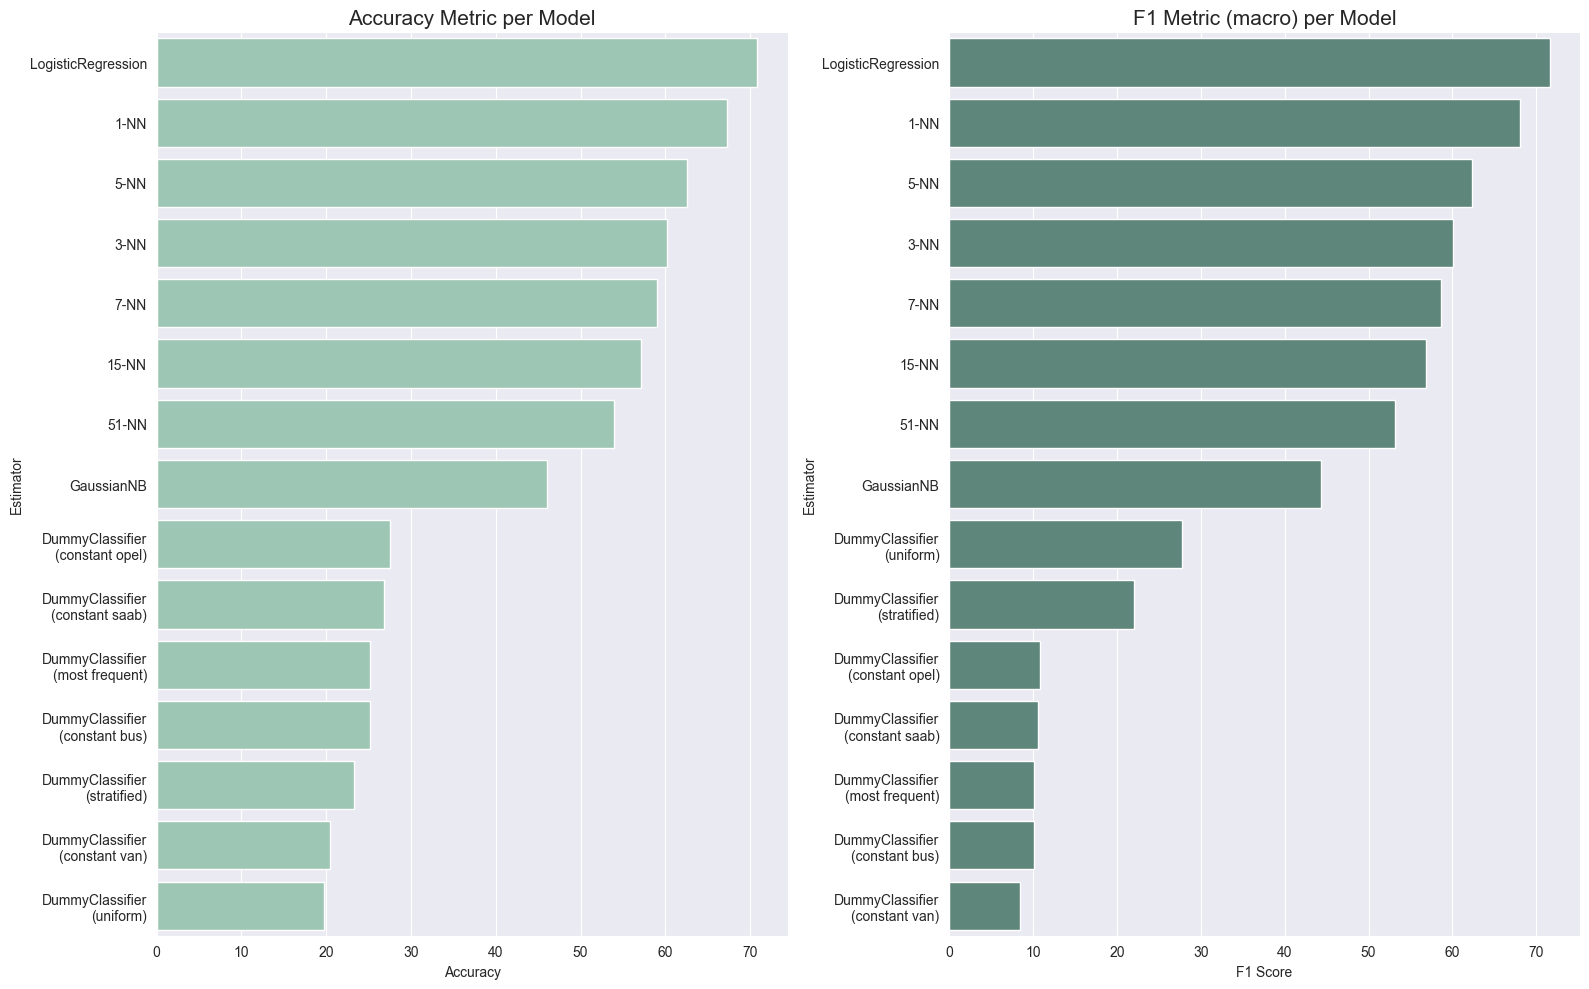

In [115]:
# Create Bar Plots for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,10))
model_labels = list(estimators.keys())
data_df = pd.DataFrame({"Accuracy":list(accuracies.values()), "Estimator":model_labels})
sns.barplot(x="Accuracy",
            y="Estimator",
            data=data_df,
            order= data_df.sort_values("Accuracy", ascending=False).Estimator,
            color=colors[1],
            ax = ax1)

data_df = pd.DataFrame({"F1 Score":list(f1_scores.values()), "Estimator":model_labels})
sns.barplot(x="F1 Score",
            y="Estimator",
            data=data_df,
            order= data_df.sort_values("F1 Score", ascending=False).Estimator,
            color = colors[0],
            ax= ax2)
#ax1.barh(model_labels, accuracies, color ='maroon')
#ax1.set_xlabel("Accuracy",  fontsize=10)
ax1.set_title("Accuracy Metric per Model",  fontsize=15)

# ax2.barh(model_labels, f1_scores, color ='blue')
#ax2.set_xlabel("F1 Score", fontsize=10)

ax2.set_title("F1 Metric (macro) per Model",  fontsize=15)
plt.tight_layout()
plt.show()

 Καταρχάς, μετράμε το macro-averaged F1 score, το οποίο υπολογίζεται χρησιμοποιώντας τον αριθμητικό μέσο (unweighted μέσο) των F1 score κάθε κλάσης (το dataset μας είναι ισορροπημένο οπότε και το weighted-averaged F1 score θα έδινε πολύ παρόμοιες τιμές). Παρατηρούμε ότι με βάση το accuracy αλλά και την μετρική F1, ο ταξινομητής **Logistic Regression** δίνει τα καλύτερα αποτελέσματα και ο αμέσως καλύτερος είναι ο Κ-ΝΝ (συγκεκριμένα ο 5-ΝΝ). Συγκεκριμένα, όσον αφορά τον τελευταίο έχουμε πειραματιστεί αρχικά με τιμές Κ = 1, 5, 15, 51 για να καταλάβουμε περίπου ποια περιοχή τιμών Κ πετυχαίνει καλύτερα αποτελέσματα και βλέποντας ότι αυτό συμβαίνει με Κ = 5 δημιουργούμε και εκπαιδεύουμε άλλους δύο ΝΝ εκτιμητές με Κ = 3 και 7 (χωρίς να πετύχουμε βελτίωση). Γνωρίζουμε ότι όσο αυξάνουμε την υπερπαράμετρο Κ σε έναν ΚΝΝ φτιάχνουμε έναν ταξινομητή με χαμηλότερη διακύμανση και υψηλότερη απόκλιση: ουσιαστικά γίνονται πιο "smooth" τα όρια απόφασης οπότε σέβεται περισσότερο την συνολική κατανομή (ταξινομεί λάθος περισσότερους outliers). Στο δικό μας dataset φαίνεται ότι οι κλάσεις είναι σχετικά κοντά μεταξύ τους οπότε διαλέγοντας μεγάλο Κ επιλέγουμε αρκετά δείγματα γειτονικής κλάσης με αποτέλεσμα να έχουμε mispredictions. Για πολύ μικρό Κ (1, 3) φαίνεται να έχουμε overfitting οπότε accuracy και f1 είναι μειωμένα. Εδώ θα μπορούσαμε να χρησιμοποιήσουμε grid search για την εύρεση του Κ με μεγαλύτερη ακρίβεια και μικρότερο κόπο όμως προτιμήσαμε να το κάνουμε χειροκίνητα για να επιδείξουμε την διαδικασία (έτσι και αλλιώς θα δούμε το grid search κατά την βελτιστοποίηση). Να σημειωθεί ότι το πρόβλημά μας έχει σχετικά μικρό πλήθος features και [αυτό γενικά βοηθάει την επίδοση του ΚΝΝ](https://www.researchgate.net/publication/232406523_An_Improved_k-Nearest_Neighbor_Algorithm_for_Text_Categorization). Όταν έχουμε πολλά features χρειάζονται περισσότερα δεδομένα και αυτό μπορεί να οδηγεί σε overfitting.

Όσον αφορά την ανωτερότητα του LR clf επί του ΚΝΝ μπορούμε να δούμε υπολογίζοντας τις μέσες τιμές ανά χαρακτηριστικό (βλέπε πίνακα παρακάτω) ότι οι κλίμακες των χαρακτηριστικών διαφέρουν αρκετά μεταξύ τους επομένως δεν έχουμε "δίκαιη" διαχείρισή τους (χρειάζεται scaling). Αυτό καθώς ένα χαρακτηριστικό με πολύ μεγάλες τιμές θα έχει μεγαλύτερη επίδραση στον υπολογισμό της απόστασης στον ΚNN από τι ένα με μικρές τιμές, χωρίς όμως απαραίτητα να είναι περισσότερο καθοριστικό για τον διαχωρισμό των κλάσεων. Δεδομένου ότι ο LR υποστηρίζει μόνο γραμμικές λύσεις φαίνεται ότι οι κλάσεις που χειρίζεται το πρόβλημά μας μπορούν με ικανοποιητική προσέγγιση να θεωρηθούν γραμμικά διαχωρίσιμες. Στον ΚΝΝ σαν να έχουμε φαινόμενο που μοιάζει με overfitting, πράγμα που φαίνεται και από τα learning curves. Παρατηρώντας το learning curve του καλύτερου από τους ΚΝΝ, του 3-ΝΝ, και του LR εκτιμητή φαίνεται ότι το accuracy του πρώτου σταθεροποιείται από τα 250 περίπου δείγματα και μετά ενώ στον LR με το πλήθος δειγμάτων που έχουμε δεν φτάνουμε σε "σημείο σύγκλισης" του accuracy. Να σημειωθεί ότι το accuracy για τις καμπύλες μάθησης είανι υπολογισμένο με την μέθοδο 10-fold cross validation.

O Naive Bayes έπεται. Ο ταξινομητής αυτός χρησιμοποιεί για τις αποφάσεις του τις a posteriori πιθανότητες που σύμφωνα με τον κανόνα του Bayes δίνονται από τον τύπο:

$$P(y|x) = \frac{P(x|y) \cdot P(y)}{P(x)}$$

Για κάθε δείγμα x υπολογίζει για κάθε κλάση y την παραπάνω πιθανότητα και το κατατάσσει στην κλάση με την μεγαλύτερη a posteriori πιθανότητα.
Δηλαδή θα κατατάξει το x στην κλάση

$$y^{*} = \underset{y}{argmax} {P(y|x)} = \underset{y}{argmax} \frac{P(x|y) \cdot P(y)}{P(x)} = \underset{y}{argmax} P(x|y) \cdot P(y)$$

Ο Naive Bayes Classifier υποθέτει ότι τα features κάθε δείγματος είναι μεταξύ τους ανεξάρτητα. Έτσι ο παραπάνω κανόνας απόφασης γίνεται:

 $$y^{*} = \underset{y}{argmax} \prod_{i}{P(x_i|y)} \cdot P(y)$$

 Με τα $x_i$ να αποτελούν τα ανεξάρτητα features. Μάλιστα στην περίπτωση μας τα features αυτά είναι οι τιμές των pixel της εικόνας και υποθέτουμε ότι ακολουθούν κανονική κατανομή. Συνεπώς ισχύει ότι:

 $$P(x_i|y) = \mathcal{Ν}(x_i;\mu_{i,y},\sigma_{i,y}) \qquad i=0,...,255$$

Η χαμηλή απόδοση του Naive Bayes οφείλεται εν μέρει στο γεγονός στην θεώρησή του ότι τα features είναι μεταξύ τους πλήρως ανεξάρτητα, κάτι που δεν κάνει ούτε ο LR ούτε ο K-NN (τα features δεν είναι μεταξύ τους πλήρως ανεξάρτητα).

Οι Dummy classifiers όπως ήταν αναμενόμενο έχουν πολύ χαμηλή απόδοση (ειδικά εφόσον το dataset είναι ισορροπημένο). Δοκιμάζουμε τις εξής τακτικές προσδιορίζοντας αντίστοιχα την παράμετρο `strategy` της κλάσης `DummyClassifier`:
* `uniform` : προβλέπει τυχαία και ομοιόμορφα (σε κάθε κλήση του predict έχουμε ξανά τυχαίες προβλέψεις).
* `constant` : προβλέπει πάντα μία κατηγορία που την διαλέγουμε εμείς. Εδώ προφανώς το accuracy που θα πετύχουμε θα είναι ίδιο με το ποσοστό των δειγμάτων της κλάσης αυτής στο test set (δεδομένου ότι η μετρική υπολογίζεται στο test set προφανώς - όχι cross validation).
* `most_frequent` : προβλέπει πάντα την πιο συχνή κατηγορία στο training set *(προσοχή: όχι στο test set, αλλά εφόσον ο χωρισμός γίνεται τυχαία πολύ πιθανό να είναι η ίδια και στο test set, δηλαδή στην περίπτωσή μας η bus - πράγματι το accuracy είναι ίδιο με εκείνο του DummyClassifier(constant bus) )*.
* `stratified` : κάνει προβλέψεις διατηρώντας την κατανομή των κλάσεων στο training set (καθώς το dataset είναι ισορροπημένο έχει παρόμοια απόδοση με τον `uniform`)

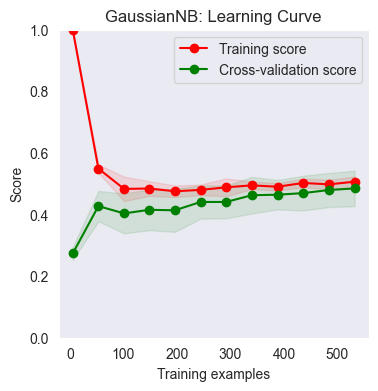

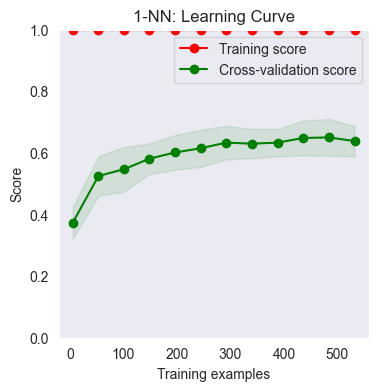

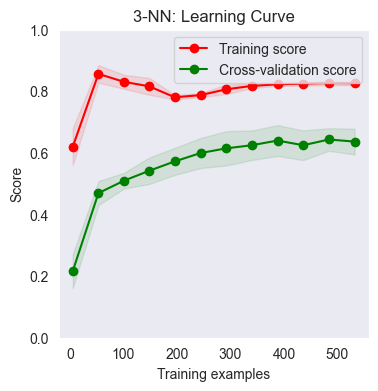

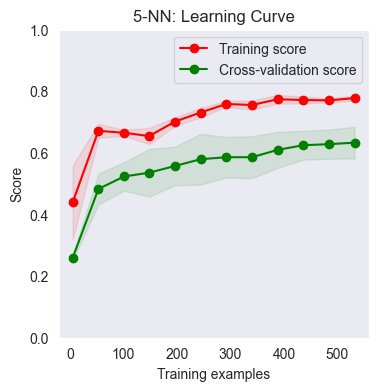

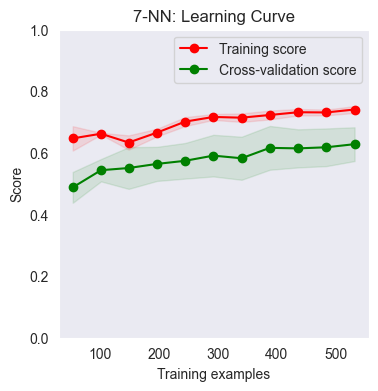

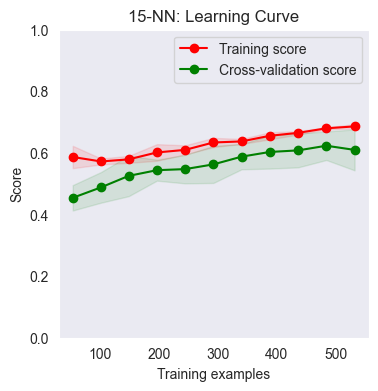

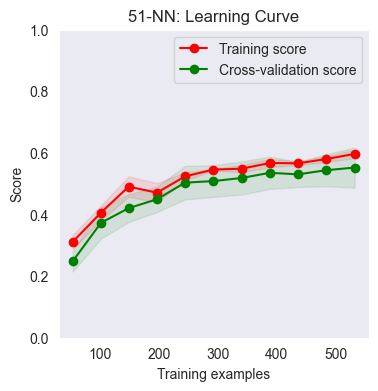

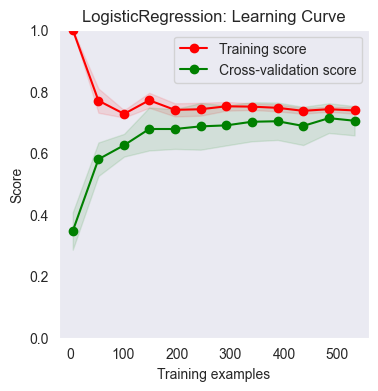

In [116]:
for clf_name, clf in estimators.items():
    if "Dummy" not in clf_name:
        plot_learning_curve(clf, clf_name)

In [17]:
calc_mean_var_per_feature(X_train)
"""
Εξετάζουμε τις τιμές των μέσων τιμών για να δούμε κατά πόσο η κανονικοποίηση θα βελτώσει την επίδοση στο dataset που έχουμε και τις διασπορές καθενός από τα 18 χαρακτηριστικά (για να βοηθηθούμε στον προορισμό πιθανών τιμών κατωφλιοποίησης για τον μετασχηματιση VarianceThreshold())
"""

| feature                            | mean value | variance | max value | min value |
| :--------------------------------: | :--------: | :------: |  :------: | :------:  |
| COMPACTNESS                        | 93.43      | 67.82    | 119.0     | 77.0      | 
| CIRCULARITY                        | 44.73      | 38.5     | 59.0      | 33.0      | 
| DISTANCE CIRCULARITY               | 81.48      | 257.33   | 112.0     | 40.0      | 
| RADIUS RATIO                       | 167.28     | 1171.14  | 333.0     | 104.0     | 
| PR.AXIS ASPECT RATIO               | 61.4       | 62.53    | 138.0     | 47.0      | 
| MAX.LENGTH ASPECT RATIO            | 8.44       | 19.86    | 55.0      | 2.0       | 
| SCATTER RATIO                      | 168.02     | 1135.47  | 265.0     | 112.0     | 
| ELONGATEDNESS                      | 41.21      | 63.61    | 61.0      | 26.0      | 
| PR.AXIS RECTANGULARITY             | 20.52      | 6.84     | 29.0      | 17.0      | 
| MAX.LENGTH RECTANGULARITY       

'\nΕξετάζουμε τις τιμές των μέσων τιμών για να δούμε κατά πόσο η κανονικοποίηση θα βελτώσει την επίδοση στο dataset που έχουμε και τις διασπορές καθενός από τα 18 χαρακτηριστικά (για να βοηθηθούμε στον προορισμό πιθανών τιμών κατωφλιοποίησης για τον μετασχηματιση VarianceThreshold())\n'

### **Βελτιστοποίηση**
Ως επόμενο στάδιο, για κάθε έναν από τους ταξινομητές βελτιστοποιούμε την επίδοσή τους μέσω των διαδικασιών:
- προεπεξεργασίας
- ορισμού pipelines και
- εύρεσης βέλτιστων υπερμαραμέτρων με αναζήτηση πλέγματος με διασταυρούμενη επικύρωση

## Προεπεξεργασία Δεδομένων
---
Στο στάδιο αυτό, ορίζουμε μετασχηματιστές για την προεπεξεργασία των δεδομένων, με στόχο τη βελτιστοποίηση της επίδοσης των εκτιμητών.

#### Κανονικοποίηση χαρακτηριστικών

 Χαρακτηριστικά με πολύ μεγάλες διαφορές στις απόλυτες τιμές τους μπορούν να προκαλέσουν προβλήματα στην εκπαίδευση και να δώσουν ταξινομητές με μη βέλτιστη απόδοση. Η κανονικοποίηση μετασχηματίζει τις τιμές των χαρακτηριστικών ώστε να αμβλυνθούν αυτές οι διαφορές. Θα δοκιμάσουμε διαίρεση με τη διαφορά μεγίστου-ελαχίστου (feature scaling) οπότε οι τιμές των χαρακτηριστικών θα κλιμακωθούν γραμμικά στο διάστημα [0,1]. Η μετατροπή μεγίστου ελαχίστου γίνεται με τον τύπο: $$X' = {X - X_{min} \over X_{max} - X_{min}}$$ και μπορούμε να χρησιμοποιήσουμε τον μετασχηματισμό `sklearn.preprocessing.MinMaxScaler()`.

Επίσης, θα κάνουμε και κανονικοποίηση με το z-score (ή standard score) του κάθε χαρακτηριστικού (standardization), που κάνει το χαρακτηριστικό ακολουθεί την κανονική κατανομή Ν(0, 1) σύμφωνα με τον τύπο: $$z = {X- \mu \over \sigma}$$ όπου: $μ$ είναι η μέση τιμή του χαρακτηριστικού και $σ$ η απόκλιση και θα χρησιμοποιήσουμε τον μετασχηματισμό `sklearn.preprocessing.StandardScaler()` (δεν μας ενδιαφέρει αν η πραγματική κατανομή των χαρακτηριστικών είναι κανονική, απλά αφαιρούμε τη μέση τιμή και διαιρούμε με την απόκλιση για να έχουν τα χαρακτηριστικά της).

H μετατροπή σε standard score είναι πιο ανθεκτική από την min-max σε τιμές outliers δηλαδή σποραδικές τιμές που είναι πολύ μακριά απο τη μέση τιμή και τις υπόλοιπες τιμές του χαρακτηριστικού (η min-max θα συμπιέσει τις περισσότερες τιμές σε ένα μικρό διάστημα. Από την άλλη, η κλιμάκωση σε [0,1] είναι λιγότερο ευαίσθητη σε πολύ μικρές. Δοκιμάσαμε και τον MinMaxScaler όμως τα αποτελέσματα ήταν απογοητευτικά και έτσι δεν τα παραθέτουμε παρακάτω (δουλεύουμε μόνο με τον Standard Scaler).

Βλέπουμε παρακάτω το intercorrelation μεταξύ των 18 features. Παρατηρούμε από το heat-map πως κάποια χαρακτηριστικά είναι έντονα συσχετισμένα με άλλα.

#### Εξισορρόπηση dataset

Το dataset μας όπως είπαμε είναι ισορροπημένο. Θα δοκιμάσουμε να χρησιμοποιήσουμε και τον μετασχηματισμό αυτό περιμένοντας να δούμε κάποια μικρή μάλλον βελτίωση.
Ορίζουμε για τον σκοπό αυτό παρακάτω τον μετασχηματισμό `imblearn.over_sampling.RandomOverSampler()`. Σε δεύτερη φάση δοκιμάσαμε τον `imblearn.under_sampling.RandomUnderSampler()` όμως τα αποτελέσματα ήταν υποδεέστερα και έτσι δεν τα παραθέτουμε παρακάτω.


#### Μείωση της διαστατικότητας με εξαγωγή χαρακτηριστικών

Για να μειώσουμε τις διαστάσεις των μεταβλητών μας μπορούμε να κάνουμε δύο πράγματα: vα αφαιρέσουμε κατηγορίες που δεν προσφέρουν *σημαντική πληροφορία*, δηλαδή να κάνουμε **επιλογή μεταβλητών (feature selection)**. Εναλλακτικά, μπορούμε να κάνουμε εξαγωγή νέων χαρακτηριστικών σε ένα χώρο μικρότερων διαστάσεων (**feature extraction**). Η βασικότερη τεχνική feature extraction είναι η **ανάλυση σε κύριες συνιστώσες (principal components analysis - PCA)** όπου αναλύουμε τα δεδομένα σε κύριες συνιστώσες και δουλέυουμε με τελείως νέες, γραμμικά ασυσχέτιστες μεταβλητές μικρότερης διαστατικότητας.

Η ανάλυση σε κύριες συνιστώσες (PCA) είναι η ευρέως διαδεδομένη μέθοδος μείωσης της διαστατικότητας. Ούτε εδώ θα εμβαθύνουμε, αλλά θα εξηγήσουμε περιγραφικά τις αρχές της μεθόδου. Αρχικά υπολογίζουμε τον πίνακα συσχέτισης (covariance matrix) των μεταβλητών που έχουμε στα δεδομένα. Από αυτόν τον πίνακα βρίσκουμε τις γραμμικώς συσχετισμένες μεταβλητές και βρίσκοντας τα ιδιοδιανύσματα του πίνακα μπορούμε να μετατρέψουμε τον πίνακα με έναν ορθογώνιο μετασχηματισμό και να βρούμε την βάση του νέου πίνακα. Αυτή η βάση του χώρου αποτελεί ένα νέο σύνολο μεταβλητών που είναι *γραμμικά ασυσχέτιστες* και ονομάζονται κύριες συνιστώσες.

Η διαστατικότητα του προβλήματος είναι 18 (έχουμε 18 features).
Ορίζουμε για τον σκοπό αυτό παρακάτω τον μετασχηματισμό `sklearn.preprocessing.PCA()`.

####
Μια απλή τεχνική επιλογής χαρακτηριστικών είναι το ελάχιστο κατώφλι της διακύμανσης (Variance threshold). Σε γενικές γραμμές αν η διακύμανση ενός χαρακτηριστικού εισόδου είναι πολύ χαμηλή, δεν μπορεί να προσφέρει σημαντικά στη διαχωριστική ικανότητα του ταξινομητή. Ειδικά στην περίπτωση που η διακύμανση είναι 0, δηλαδή το χαρακτηριστικό έχει σταθερή τιμή για όλα τα δείγματα εκπαίδευσης, δεν χρησιμεύει καθόλου στον ταξινομητή για να αποφασίσει αν ένα δείγμα ανήκει σε μία κλάση ή σε μια άλλη και επιπλέον μπορεί να δυσκολέψει άλλες διαδικασίες της προεπεξεργασίας όπως η κανονικοποίηση των χαρακτηριστικών.

Μπορούμε να χρησιμοποιήσουμε τη συνάρτηση VarianceThreshold για να αφαιρέσουμε τα  χαρακτηριστικά στο training set που έχουν μηδενική διακύμανση (default) ή πολύ χαμηλή. Πρέπει επίσης να πάρουμε μια μάσκα (index) των χαρακτηριστικών που επιλέγουμε, ώστε να την εφαρμόσουμε και στα δεδομένα train ώστε να έχουν τις ίδιες διαστάσεις. Αυτό δεν σπάει τον κανόνα ότι δεν χρησιμοποιούμε τα δεδομένα test γιατί μπορούμε να θεωρήσουμε ότι ο ταξινομητής απλώς αγνοεί τις εισόδους που δεν περιλαμβάνονται στη μάσκα.  Ας δούμε τη VarianceThreshold στο dataset:

| feature                            | variance |
| :--------------------------------: |:--------:|
| COMPACTNESS                        |  67.82   |
| CIRCULARITY                        |   38.5   |
| DISTANCE CIRCULARITY               |  257.33  |
| RADIUS RATIO                       | 1171.14  |
| PR.AXIS ASPECT RATIO               |  62.53   |
| MAX.LENGTH ASPECT RATIO            |  19.86   |
| SCATTER RATIO                      | 1135.47  |
| ELONGATEDNESS                      |  63.61   |
| PR.AXIS RECTANGULARITY             |   6.84   |
| MAX.LENGTH RECTANGULARITY          |  215.25  |
| SCALED VARIANCE ALONG MAJOR AXIS   |  025.53  |
| SCALED VARIANCE ALONG MINOR AXIS   | 31956.21 |
| SCALED RADIUS OF GYRATION          | 1055.42  |
| SKEWNESS ABOUT MINOR AXIS          |  52.57   |
| SKEWNESS ABOUT MAJOR AXIS          |  22.61   |
| KURTOSIS ABOUT MINOR AXIS          |  83.74   |
| KURTOSIS ABOUT MAJOR AXIS          |  36.26   |
| HOLLOWS RATIO                      |  54.13   |

Ορίζουμε για τον σκοπό αυτό παρακάτω τον μετασχηματισμό `sklearn.preprocessing.Variance Thresholder()`.


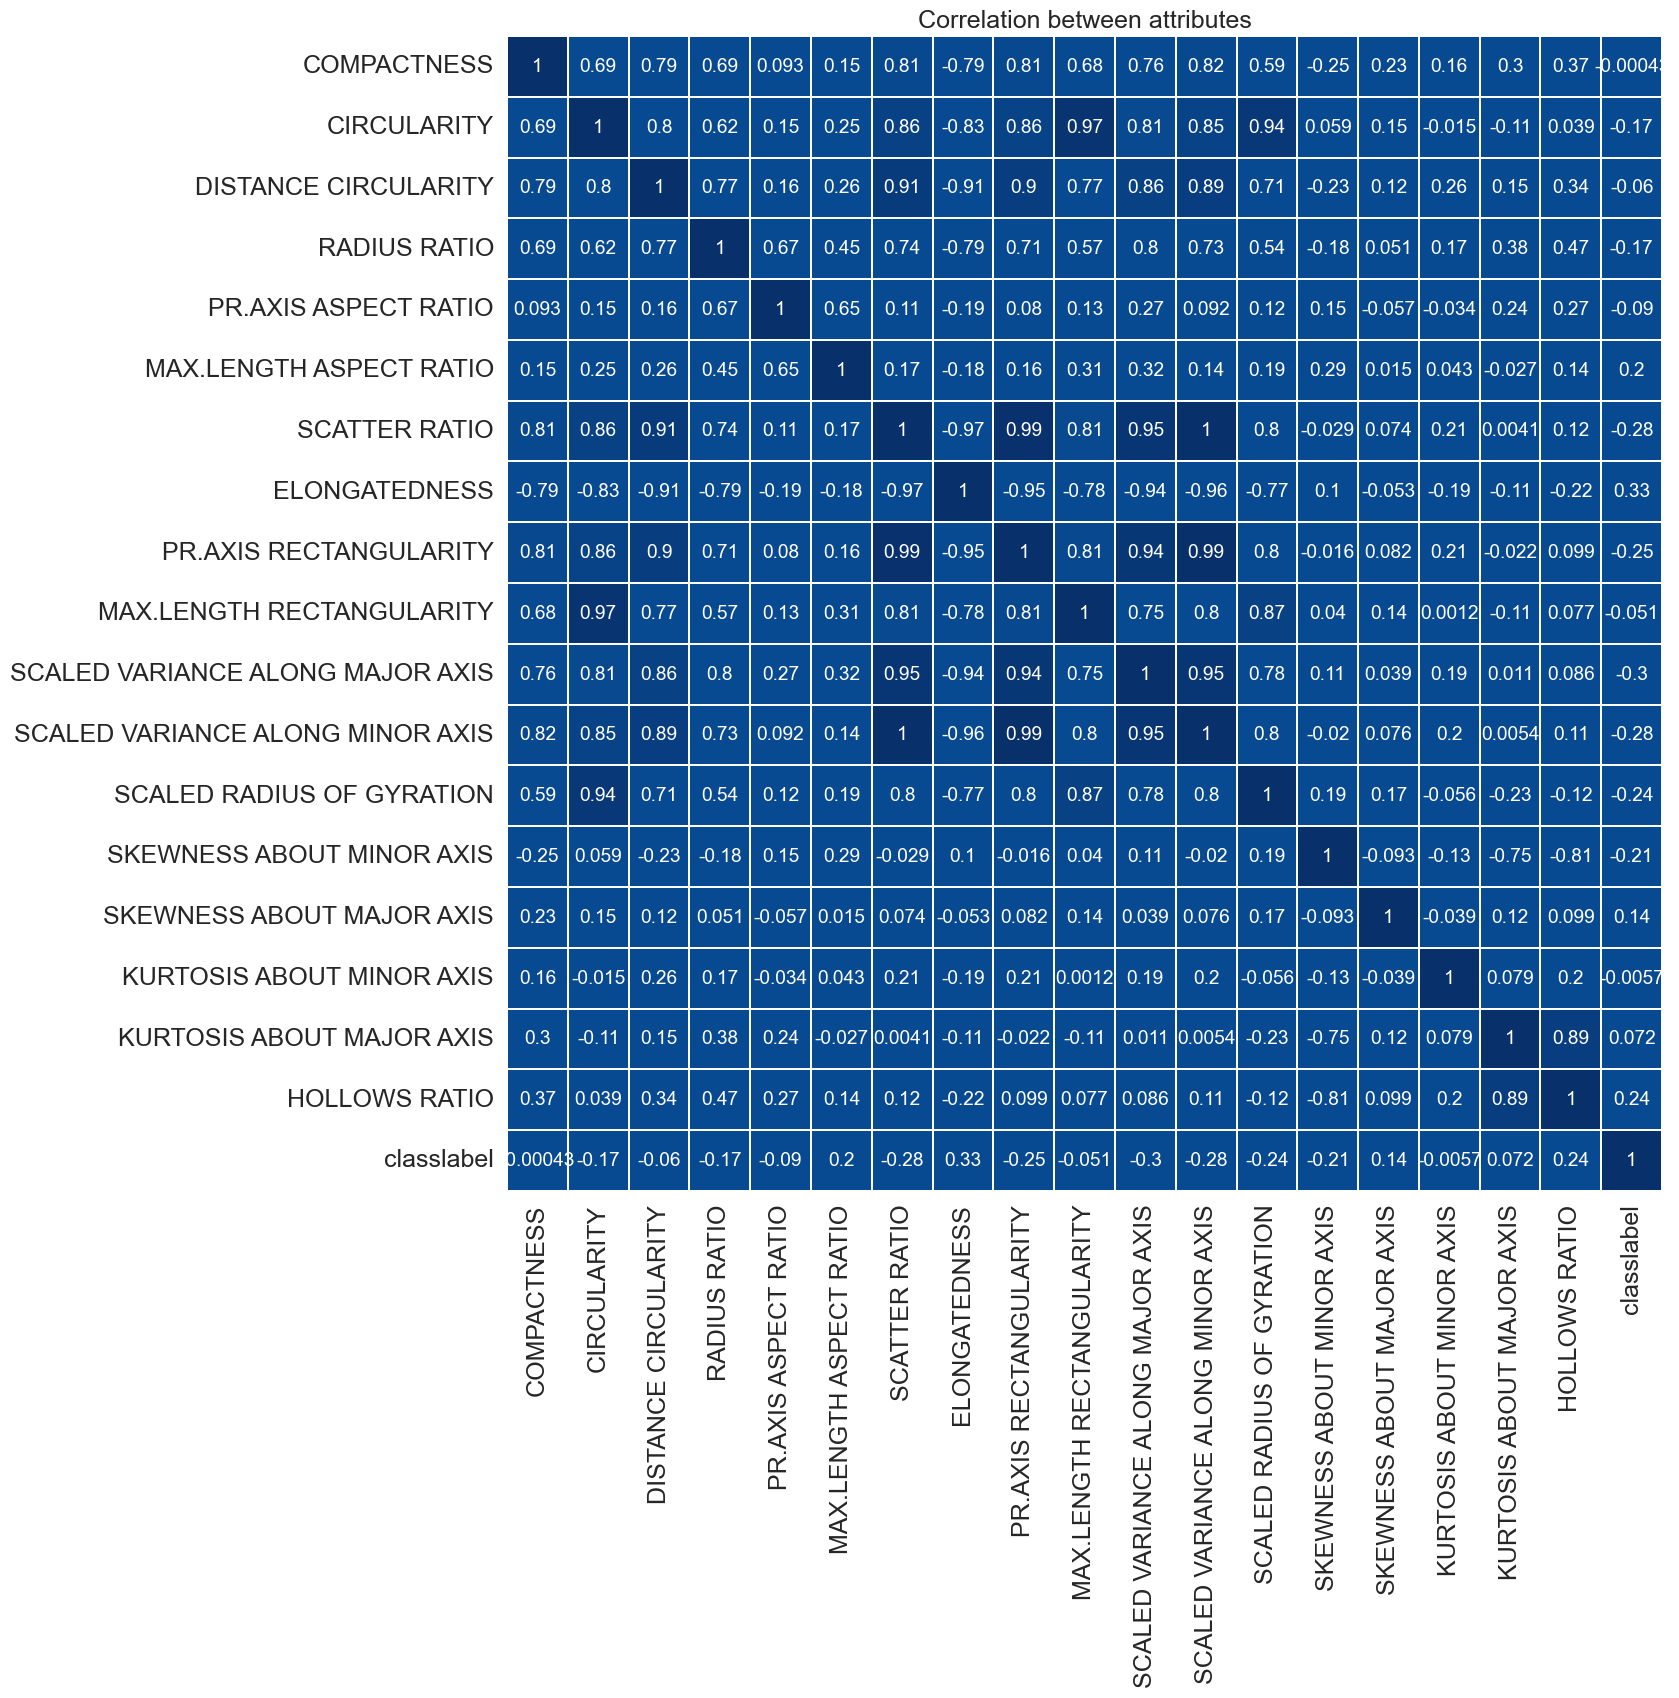

In [189]:
cor = data.corr()

sns.set(font_scale=1.15)
fig,ax=plt.subplots(figsize=(18,15))
sns.heatmap(cor,vmin=0.8, annot=True,linewidths=0.01,center=0,linecolor="white",cbar=False,square=True, cmap="Blues")
plt.title('Correlation between attributes',fontsize=18)
ax.tick_params(labelsize=18)

In [175]:
# initialize transformers without any hyperparameters
selector = VarianceThreshold()
scaler = StandardScaler()
ros = RandomOverSampler()
#ros = RandomUnderSampler()
pca = PCA()

#### Pipelines
Για την κατασκευή του μοντέλου χρησιμοποιούμε την έτοιμη κλάση `Pipeline` της imblearn (όχι της sklearn καθώς εκείνη υποστηρίζει την μέθοδο transform για τους samplers).
Ορίζουμε ένα pipeline για κάθε έναν από τους εκτιμητές. Σε καθένα από τα pipelines εφαρμόζουμε fit και predict (το pipeline συμπεριφέρεται ως ένας ενιαίος εκτιμητής).

In [180]:
# Create Baseline Estimators and Pipelines
estimators = {"dummy": DummyClassifier(strategy="uniform"),
              "GaussianNB": GaussianNB(),
              "KNN": KNeighborsClassifier(metric='manhattan',n_jobs=-1),
              "LR" : LogisticRegression(n_jobs=-1)}

#list of pipes, one for each estimator
pipes = []
for estimator in estimators.values():
  pipes.append(Pipeline(steps=[
    ('selector', selector),
    ('scaler', scaler),
    ('sampler', ros),
    ('pca', pca),
    ('estimator', estimator)
  ], memory = 'tmp'))


# pipes[1].fit(X_train, y_train)
# preds = pipes[1].predict(X_test)
# print(classification_report(y_test, preds))
#
# pipes[2].fit(X_train, y_train)
# preds = pipes[2].predict(X_test)
# print(classification_report(y_test, preds))
#
# pipes[3].fit(X_train, y_train)
# preds = pipes[3].predict(X_test)
# print(classification_report(y_test, preds))

*ΣΗΜΕΙΩΣΗ*: Στην διαδικασία βελτιστοποίησης θα λάβουμε υπόψη και τον Dummy Classifier για λόγους πληρότητας, γνωρίζοντας ωστόσο ότι η βελτιστοποίηση του δεν έχει κανένα απολύτως νόημα.

Ορίζουμε για κάθε παράμετρο ένα πεδίο ορισμού και φτιάχνουμε ένα grid για όλους του συνδυασμούς υπερπαραμέτρων με χρήση του `GridSearvhCV`. Αυτό για κάθε τιμή υπερπαραμέτρων του grid υπολογίζει τον μέσο όρο του εκτιμητή σε όλα τα folds του cross-validation και αναζητεί (exhaustive search) την βέλτιστη σύμφωνα με την μετρική που έχουμε προσδιορίσει (πρώτα το accuracy και μετά το F1). Τo 10-fold cross-validation και η exhaustive search στο grid καθιστά την στρατηγική αναζήτησης αυτή υπολογιστικά ακριβή.

In [178]:
#########################################
#HYPERPARAMETERS#########################
#########################################

# Hyperparameters for variance thresholding
vthreshold = [0, 10, 20, 25, 30]

# Hyperparameters for Principal Component Analysis
n_components = np.arange(1, 19)

#Hyperparameters for sampling
sampling_strategy = ['majority', 'not minority', 'not majority', 'all']


# Hyperparameters for each estimator
####################################

# Dummy Classifier Hyperparameters
strategy = ['stratified', 'most_frequent', 'prior', 'uniform', 'constant'] # is it really necessary for dummy?

# Gaussian NB Classifier Hyperparameters
var_smoothing = [1e-9, 1e-5, 1e-3, 1]

# KNN Classifier Hyperparameters
#δοκιμάζουμε τιμές Κ με βάση τις προηγούμενες παρατηρήσεις μας (είδαμε μικρές τιμές Κ δίνουν τα καλύτερα αποτελέσματα)
#θα δοκιμάσουμε τώρα και διαφορετικές μετρικές αποστάσεων
n_neighbors = np.arange(1, 16) #step = 1 => try 1, 2, 3, ..., 15
metric = ['euclidean', 'manhattan', 'minkowski', 'mahalanobis']

# Logistic Regression Hyperparameters
max_iter = np.arange(100, 10000, 500)
penalty = ['l1', 'l2']
solver = ['lbfgs', 'liblinear', 'saga']

#### Βελτιστοποίηση ως προς το **Accuracy**

In [44]:
##################
# accuracy #######
##################
"""
Define GridSearch Estimators for each classifier
we want to find hyperparameters that optimize accuracy
"""
# Define GridSearch Estimators for each classifier
estimator_dummy = GridSearchCV(pipes[0], dict(selector__threshold=vthreshold,
                                              pca__n_components=n_components, estimator__strategy=strategy), cv=10, scoring='f1_macro', n_jobs=-1)

estimator_nb = GridSearchCV(pipes[1], dict(selector__threshold=vthreshold,
                                              pca__n_components=n_components, estimator__var_smoothing=var_smoothing), cv=10, scoring='f1_macro', n_jobs=-1)

estimator_knn = GridSearchCV(pipes[2], dict(selector__threshold=vthreshold,
                                            sampler__sampling_strategy= sampling_strategy,
                                            pca__n_components=n_components, estimator__n_neighbors=n_neighbors,
                                            estimator__metric=metric), cv=10, scoring='f1_macro', n_jobs=-1)

estimator_lr = GridSearchCV(pipes[3], dict(selector__threshold=vthreshold,
                                          pca__n_components=n_components, estimator__max_iter=max_iter,
                                          estimator__penalty=penalty, estimator__solver=solver), cv=10, scoring='f1_macro', n_jobs=-1)
"""
Κάνουμε fit τους παραπάνω (pipeline) estimators στο train set και βρίσκουμε στο διάστημα αναζήτησης που έχουμε (προσεκτικά) επιλέξει τις
βέλτιστες υπερπαραμέτρους για κάθε έναν από αυτούς.
"""
# Find Optimal Hyperparameters for Dummy Classifier
print("####################################################################")
estimator_dummy.fit(X_train, y_train)
best_dummy_acc = estimator_dummy.best_estimator_
print(best_dummy_acc)
print(estimator_dummy.best_params_)

# Find Optimal Hyperparameters for Gaussian NB Classifier
print("####################################################################")
estimator_nb.fit(X_train, y_train)
best_nb_acc = estimator_nb.best_estimator_
print(best_nb_acc)
print(estimator_nb.best_params_)

# Find Optimal Hyperparameters for KNN Classifier
print("####################################################################")
estimator_knn.fit(X_train, y_train)
best_knn_acc = estimator_knn.best_estimator_
print(best_knn_acc)
print(estimator_knn.best_params_)

# Find Optimal Hyperparameters for LR Classifier
print("####################################################################")
# estimator_lr.fit(X_train, y_train)
# best_lr_acc = estimator_lr.best_estimator_
# print(best_lr_acc)
# print(estimator_lr.best_params_)


####################################################################
Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0)),
                ('scaler', StandardScaler()), ('sampler', RandomOverSampler()),
                ('pca', PCA(n_components=16)),
                ('estimator', DummyClassifier(strategy='uniform'))])
{'estimator__strategy': 'uniform', 'pca__n_components': 16, 'selector__threshold': 0}
####################################################################
Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=25)),
                ('scaler', StandardScaler()), ('sampler', RandomOverSampler()),
                ('pca', PCA(n_components=15)), ('estimator', GaussianNB())])
{'estimator__var_smoothing': 1e-09, 'pca__n_components': 15, 'selector__threshold': 25}
####################################################################
Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0)),
          

In [183]:
estimator_lr = GridSearchCV(pipes[3], dict(selector__threshold=vthreshold,
                                          pca__n_components=n_components, estimator__max_iter=max_iter,
                                          estimator__penalty=penalty, estimator__solver=solver), cv=10, scoring='f1_macro', n_jobs=-1)
estimator_lr.fit(X_train, y_train)
best_lr_acc = estimator_lr.best_estimator_
print(best_lr_acc)
print(estimator_lr.best_params_)


Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=20)),
                ('scaler', StandardScaler()), ('sampler', RandomOverSampler()),
                ('pca', PCA(n_components=16)),
                ('estimator',
                 LogisticRegression(max_iter=1100, n_jobs=-1, penalty='l1',
                                    solver='saga'))])
{'estimator__max_iter': 1100, 'estimator__penalty': 'l1', 'estimator__solver': 'saga', 'pca__n_components': 16, 'selector__threshold': 20}


In [185]:
"""
Για τα βέλτιστα μοντέλα, καταγράφουμε τους χρόνους train και test καθώς και την επίδοσή τους (accuracy, macro & weighted average F1)
"""
best_estimators = [best_dummy_acc, best_nb_acc, best_knn_acc, best_lr_acc]
labels = ['Dummy Classifier', 'Gaussian NB Classifier', 'KNN Classifier', 'LR Classifier']
print("Optimization w.r.t. accuracy:")
print("#######################################################")
evaluations1 = []
for i in range(len(best_estimators)):
  print('################ '+labels[i]+' ###################\n')
  metrics, train_time, test_time = evaluate_best(best_estimators[i], X_train, X_test, y_train, y_test, 'accuracy')
  evaluations1.append((metrics, train_time, test_time))
  print('Accuracy = '+str(100*metrics)+'%')
  print('Train Time = '+str(1000*train_time)+' msec')
  print('Evaluation Time = '+str(1000*test_time)+' msec\n')

estimators_to_plot = ["GaussianNB", "5-NN" , "LogisticRegression"]
#initial
accs = [accuracies[est] for est in estimators_to_plot]
print("##########################################################")
for i in range(len(best_estimators)-1):
  metrics, train_time, test_time = evaluations1[i+1]
  metrics = 100*metrics
  print(f'{labels[i+1]} | {accs[i]} |{metrics:.3f} | {metrics-accs[i]:.3f} |{1000*train_time:.3f} | {1000*test_time:.3f}')

print()

Optimization w.r.t. accuracy:
#######################################################
################ Dummy Classifier ###################

              precision    recall  f1-score   support

           0       0.25      0.27      0.26        64
           1       0.28      0.21      0.24        70
           2       0.25      0.25      0.25        68
           3       0.21      0.25      0.23        52

    accuracy                           0.24       254
   macro avg       0.25      0.24      0.24       254
weighted avg       0.25      0.24      0.24       254

Accuracy = 24.409448818897637%
Train Time = 10.876178741455078 msec
Evaluation Time = 1.0001659393310547 msec

################ Gaussian NB Classifier ###################

              precision    recall  f1-score   support

           0       0.89      0.92      0.91        64
           1       0.66      0.57      0.61        70
           2       0.66      0.69      0.68        68
           3       0.82      0.88  

#### Βελτιστοποίηση ως προς την μετρική F1_macro

Επαναλαμβάνουμε τα παραπάνω βήματα αλλάζοντας μόνο την μετρική που θέλουμε να βελτιστοποιήσουμε. Θέλουμε να προσδιορίζουμε τις υπερπαραμέτρους που δίνουν την υψηλότερη τιμή F1 macro.

In [24]:
# Define GridSearch Estimators for each classifier
estimator_dummy = GridSearchCV(pipes[0], dict(selector__threshold=vthreshold,
                                              pca__n_components=n_components, estimator__strategy=strategy), cv=10, scoring='f1_macro', n_jobs=-1)

estimator_nb = GridSearchCV(pipes[1], dict(selector__threshold=vthreshold,
                                              pca__n_components=n_components, estimator__var_smoothing=var_smoothing), cv=10, scoring='f1_macro', n_jobs=-1)

estimator_knn = GridSearchCV(pipes[2], dict(selector__threshold=vthreshold,
                                            pca__n_components=n_components, estimator__n_neighbors=n_neighbors,
                                            estimator__metric=metric), cv=10, scoring='f1_macro', n_jobs=-1)

estimator_lr = GridSearchCV(pipes[3], dict(selector__threshold=vthreshold,
                                           pca__n_components=n_components, estimator__max_iter=max_iter,
                                           estimator__penalty=penalty, estimator__solver=solver), cv=10, scoring='f1_macro', n_jobs=-1)


In [25]:
# Find Optimal Hyperparameters for Dummy Classifier
estimator_dummy.fit(X_train, y_train)
best_dummy_f1 = estimator_dummy.best_estimator_
print(estimator_dummy.best_estimator_)
print(estimator_dummy.best_params_)

# Find Optimal Hyperparameters for Gaussian NB Classifier
estimator_nb.fit(X_train, y_train)
best_nb_f1 = estimator_nb.best_estimator_
print(estimator_nb.best_estimator_)
print(estimator_nb.best_params_)

# Find Optimal Hyperparameters for KNN Classifier
estimator_knn.fit(X_train, y_train)
best_knn_f1 = estimator_knn.best_estimator_
print(estimator_knn.best_estimator_)
print(estimator_knn.best_params_)

# Find Optimal Hyperparameters for LR Classifier
estimator_lr.fit(X_train, y_train)
best_lr_f1 = estimator_lr.best_estimator_
print(estimator_lr.best_estimator_)
print(estimator_lr.best_params_)



Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=10)),
                ('scaler', StandardScaler()), ('sampler', RandomOverSampler()),
                ('pca', PCA(n_components=15)),
                ('estimator', DummyClassifier(strategy='uniform'))])
{'estimator__strategy': 'uniform', 'pca__n_components': 15, 'selector__threshold': 10}
Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=25)),
                ('scaler', StandardScaler()), ('sampler', RandomOverSampler()),
                ('pca', PCA(n_components=15)), ('estimator', GaussianNB())])
{'estimator__var_smoothing': 1e-09, 'pca__n_components': 15, 'selector__threshold': 25}
Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0)),
                ('scaler', StandardScaler()), ('sampler', RandomOverSampler()),
                ('pca', PCA(n_components=14)),
                ('estimator',
                 KNeighborsClassifier(metric='manhattan', 

In [172]:
best_estimators = [best_dummy_f1, best_nb_f1, best_knn_f1, best_lr_f1]

labels = ['Dummy Classifier', 'Gaussian NB Classifier', 'KNN Classifier', 'LR Classifier']
print("Optimization w.r.t. F1_macro:")
print("#######################################################")
evaluations2 = []
for i in range(len(best_estimators)):
  print('################ '+labels[i]+' ###################\n')
  metrics, train_time, test_time = evaluate_best(best_estimators[i], X_train, X_test, y_train, y_test, 'macro avg')
  print('F1 Metric = '+str(100*metrics['f1-score'])+'%')
  print('Train Time = '+str(1000*train_time)+' msec')
  print('Evaluation Time = '+str(1000*test_time)+' msec\n')
  evaluations2.append((metrics, train_time, test_time))

estimators_to_plot = ["GaussianNB", "5-NN" , "LogisticRegression"]
#initial
f1s = [f1_scores[est] for est in estimators_to_plot]
print("##########################################################")
for i in range(len(best_estimators)-1):
  metrics, train_time, test_time = evaluations2[i+1]
  metrics = 100*metrics['f1-score']
  print(f'{labels[i+1]} | {f1s[i]} |{metrics:.3f} | {metrics-f1s[i]:.3f} |{1000*train_time:.3f} | {1000*test_time:.3f}')

print()

Optimization w.r.t. F1_macro:
#######################################################
################ Dummy Classifier ###################

              precision    recall  f1-score   support

           0       0.24      0.22      0.23        64
           1       0.30      0.31      0.31        70
           2       0.39      0.37      0.38        68
           3       0.25      0.27      0.26        52

    accuracy                           0.30       254
   macro avg       0.29      0.29      0.29       254
weighted avg       0.30      0.30      0.30       254

F1 Metric = 29.556444292385496%
Train Time = 10.623931884765625 msec
Evaluation Time = 0.0 msec

################ Gaussian NB Classifier ###################

              precision    recall  f1-score   support

           0       0.89      0.92      0.91        64
           1       0.66      0.57      0.61        70
           2       0.66      0.69      0.68        68
           3       0.82      0.88      0.85      

#### Αποτελέσματα και Συμπεράσματα
---

Παρακάτω φαίνονται πίνακες αποτίμησης των μοντέλων ως προς τις δύο μετρικές, οι οποίοι περιλαμβάνουν επιπλέον την μεταβολή των μετρικών σε σχέση με την out-of-the-box υλοποίηση καθώς και τους δύο χρόνους training και αξιολόγησης στο test set των εκτιμητών.


|Accuracy per Model|
|:--:|

|       Estimator        |Accuracy (%) | Out-of-the-box Accuracy (%) | Change from out-of-the-box (%)  |Train Time (msec) |Test Time (msec)|
|:----------------------:|:-----------:|:---------------------------:|:-------------------------------:|:----------------:|:--------------:|
Gaussian NB Classifier | 46.063 |75.591 | 29.528 |10.869 | 1.016
KNN Classifier | 62.598 |70.866 | 8.268 |11.391 | 26.921
LR Classifier | 70.866 |79.921 | 9.055 |354.914 | 1.001



|F1 per Model|
|:--:|

| Estimator | F1 macro (%) | Out-of-the-box Accuracy (%)  | Change from out-of-the-box (%) |Train Time (msec)|Test Time (msec)|
| :------------------: |:----------------:|:----------------------------:|:-----------------:| :-----------: | :-----------: |
Gaussian NB Classifier | 44.372 |75.245 | 30.873 |8.619 | 0.000
KNN Classifier | 62.346 |70.931 | 8.585 |8.075 | 24.260
LR Classifier | 71.628 |79.410 | 7.782 |339.024 | 0.979
To dataset αυτό παρατηρούμε ότι "ταβανιάζει" εύκολα και από εκεί και πέρα (accuracy, f1_score ~ 80%) περαεταίρω βελτίωσή του είναι δύσκολη ([αυτό είναι σύμφωνο με την υπάρχουσα σχετική βιβλιογραφία](https://www.sciencedirect.com/science/article/abs/pii/S0957417415008143)).
 Οι παρατηρήσεις για την βελτίωση ως προς F1 macro είναι ανάλογες με εκείνες ως προς accuracy (τα αποτελέσματα ως προς accuracy είναι ποιοτικά ίδια με αυτά της F1-score). Γενικότερα, παρατηρούμε ότι η κατάταξη των ταξινομητών ως προς τις επιδόσεις τους και ως προς το accuracy και την F1 (macro) είναι μεταξύ τους ίδιες.

Τις **υψηλότερες επιδόσεις** δίνει πάλι ο **Logistic Regression** Classifier, επιτυγχάνοντας accuracy και f1_score (macro) ~ **80%**. Όπως φαίνεται και από τον χρόνο εκτέλεσης είναι αρκετά efficient στην εκπαίδευση. Όπως γνωρίζουμε οι LR ταξινομητές έχουν συνήθως καλό accuracy και είναι λιγότερο επιρρεπής σε overfitting όταν το dataset είναι μικρό. Επίσης, όπως προαναφέρθηκε η καλή του επίδοση μάλλον είναι ενδεικτική του ότι το dataset είναι γραμμικά διαχωρίσιμο. Παρατηρούμε ότι για να αυξήσει την επίδοσή του διώχνει κάποια χαρακτηριστικά με μικρό variance (<30 οπότε μένουν 16 features) και στην συνέχεια μέσω pca μετασχηματίζει τους data άξονες σε principal (affine transformation, δεν χρησιμοποιείται το PCA ως dimensionality reduction) μειώνοντας το intercorrelation μεταξύ των νέων components. Στην περίπτωση του LR αυτός (PCA) είναι ο μετασχηματισμός στον οποίο οφείλεται κατά κύριο λόγο η αύξηση της επίδοσης (που είναι λογικό δεδομένου ότι το intercorrelation μεταξύ των features είναι γνωστό για την αρνητική που επίδραση στην επίδοση του LR classifier).

Μετά τις βελτιώσεις ο Gaussian NB έχει την αμέσως μικρότερη επίδοση (και ως προς accuracy και F1 macro). Παρατηρούμε ότι ο Gaussian NB είναι ο εκτιμητής που επιτυγχάνει την **μεγαλύτερη βελτίωση** ως προς την out-of-the box υλοποίησή του. Ενώ αρχικά η επίδοσή του δεν είναι καθόλου ικανοποιητική (accuracy, F1 macro <50%, ~45% ) καταφέρνει μετά τους μετασχηματισμούς να φτάσει ~75% (accuracy και F1 macro) ξεπερνώντας τον ΚΝΝ. Πειραματιζόμενοι με τους μετασχηματιστές που χρησιμοποιούμε καταλαβαίνουμε ότι η βελτίωση αυτή οφείλεται κυρίως στην PCA και στον selector (variance threshold). Ως υπερπαράμετρος var_smoothing του GNB επιλέγεται η default τιμή, 1e-09, όμως η επίδοση έχει "ταβανιάσει" και οι τιμές που δοκιμάζουμε δεν φαίνεται να την διαφοροποιούν ιδιαίτερα.

Πολύ κοντά ακολουθεί ο KNN, την επίδοση του οποίου καταφέρνει να βελτιώσει κατά κυριότερο λόγο το scaling των δεδομένων καθώς και η αλλαγή της μετρικής απόστασης (`metric='manhattan'`) και η εφαρμογή PCA (όπως είπαμε η μικρή διαστατικότητα του προβλήματος βοηθάει τον ΚΝΝ). Η βέλτιστη υπερπαράμετρος του ταξινομητή είναι η default `K = 5`. Καθώς είδαμε και προηγουμένως ότι για σχετικά μικρές τιμές Κ έχουμε τις καλύτερες επιδόσεις έχουμε στενέψει σημαντικά το διάστημα αναζήτησης ώστε να μπορούμε να εξετάσουμε όλες τις δυνατές τιμές Κ σε αυτό ($ Κ \in [1, 15]$). Όπως προαναφέρθηκε, όπως φαίνεται από τον πίνακα mean, min, max τιμών και variance, οι τιμές των δεδομένων μας διαφοροποιούνται σημαντικά ως προς την κλίμακά τους και αυτό υπονομεύει την επίδοση του ΚΝΝ καθώς ένα χαρακτηριστικό με πολύ μεγάλες τιμές θα έχει μεγαλύτερη επίδραση στον υπολογισμό της απόστασης στον ΚNN από τι ένα με μικρές τιμές, χωρίς όμως απαραίτητα να είναι περισσότερο καθοριστικό για τον διαχωρισμό των κλάσεων.

Να σημειωθεί ότι όσον αφορά τους χρόνους στο test set ο ΚΝΝ είναι με διαφορά ο **πιο αργός** (και είναι και δαπανηρός και σε μνήμη εκτός από χρόνο εφόσον χρειάζεται να κρατάει ολόκληρο το training dataset στην μνήμη για τα predictions του). Οι μεγαλύτεροι χρόνοι εκτέλεσης για το evaluation του test set είναι λογικοί δεδομένου για κάθε νέο δείγμα πρέπει να υπολογίσει τις αποστάσεις του από όλα τα υπόλοιπα δείγματα του dataset για να αποφασίσει σε ποια κατηγορία από τις 4 ανήκει. Εδώ να υπογραμμιστεί ότι αναφερόμαστε στους χρόνους στο test set. Όσον αφορά τον χρόνο εκπαίδευσης, πιο αργός είναι ο LR. Επιλέγεται από το grid search `max_iter = 2100` που είναι σχετικά μεγάλο (η default τιμή είναι 100). Γενικά, η αργή σύγκλιση οφείλεται μάλλον στο multicolinearity (δηλαδή στο correlation μεταξύ των features, ακόμα και μετά το PCA) που οδηγεί σε coefficients που αλλάζουν σημαντικά χωρίς στην πραγματικότητα να επηρεάζουν πολλά predictions/scores.

Σε κάποια πειράματα παρατηρήσαμε ότι μετά τις βελτιώσεις έχουμε και καλύτερα ή και χειρότερα που είναι λογικό εφόσον η διαδικασία είναι στοχαστική - το split του dataset σε train και test set είναι διαφορετικό κάθε φορά που τρέχουμε το notebook οπότε τα αποτελέσματα διαφοροποιούνται).

Σε κάθε περίπτωση, με την χρήση του RandomOverSampler αναιρούμε την μικρή ανισορροπία που υπάρχει στο dataset βελτιώνοντας λίγο περισσότερο την βελτίωση.

Τέλος, παρατηρούμε ότι όλοι οι pipeline estimator επιλέγουν για την Primary Component Analysis n_components μεταξύ του 14 και του 16. Ας δούμε τι πληροφορία χάνεται καθώς μειώνουμε το πλήθος των κύριων συνιστωσών θα δούμε τι ποσοστό διακύμανσης εξηγείται σε συνάρτηση του αριθμού κύριων συνιστωσών. Παρατηρούμε ότι για το πλήθος components αυτό εξηγούμε σχεδόν το 100% της διακύμανσης (πληροφορίας) του dataset επομένως έτσι καταλαβαίνουμε την επιλογή αυτή που προκύπτει από το grid search.


*Σημείωση: Ο μοναδικός ταξινομητής που έχει αρνητική μεταβολή σε σχέση με την out-of-the-box είναι ο dummy classifier. Πρόκειται για έναν baseline ταξινομητή που στηρίζεται πλήρως στην τυχαιότητα ως προς την κατηγοριοποίηση δειγμάτων. Η βελτιστοποίηση των υπερπαραμέτρων του, λοιπόν, δεν έχει κάποια ουσιαστική υπόσταση.*


[0.95961578 0.97798591 0.98948149 0.99317754 0.99520615 0.99652344
 0.99766823 0.99842448 0.99901659 0.99934049 0.99957275 0.99973093
 0.99985748 0.99992628 0.99997312 0.99999146 0.99999812 1.        ]


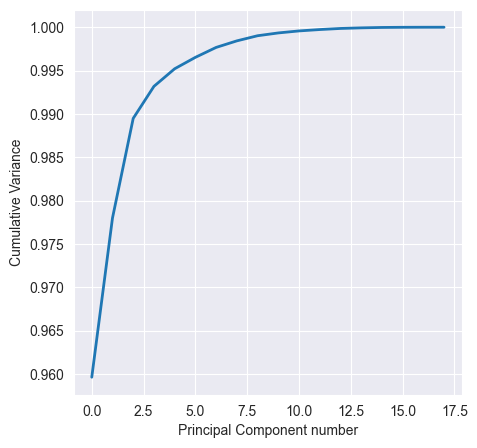

In [74]:
# Θα τυπωσουμε το συσσωρευτικό ποσοστό διασποράς που εξηγείται από τις κύριες συνιστώσες
pca.fit(X_train, y_train)
evar = pca.explained_variance_ratio_
cum_evar = np.cumsum(evar)
print(cum_evar)
plt.figure(1, figsize=(5, 5))
plt.xlabel("Principal Component number")
plt.ylabel('Cumulative Variance')
plt.plot(cum_evar, linewidth=2)
plt.show()


Οπτικοποιούμε τα αποτελέσματα για τις δύο μετρικές με χρήση bar plots:

[75.591, 70.866, 79.921] [46.063, 62.598, 70.866]


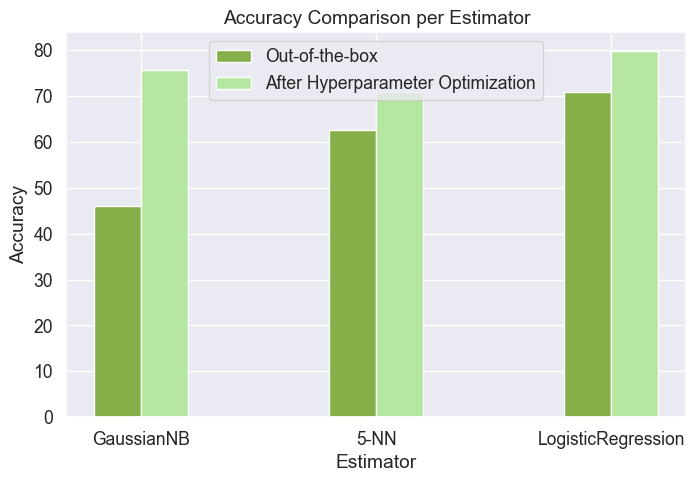

In [186]:
estimators_to_plot = ["GaussianNB", "5-NN" , "LogisticRegression"]

#initial
accs = [accuracies[est] for est in estimators_to_plot]

#optimazed
# Get metrics from tuple (metric, train_time, test_time)
optimal_accs = [np.round(i[0]*100, 3) for i in evaluations1[1:]]

print(optimal_accs, accs)

plot_comparison(optimal_accs, accs, title='Accuracy Comparison per Estimator')

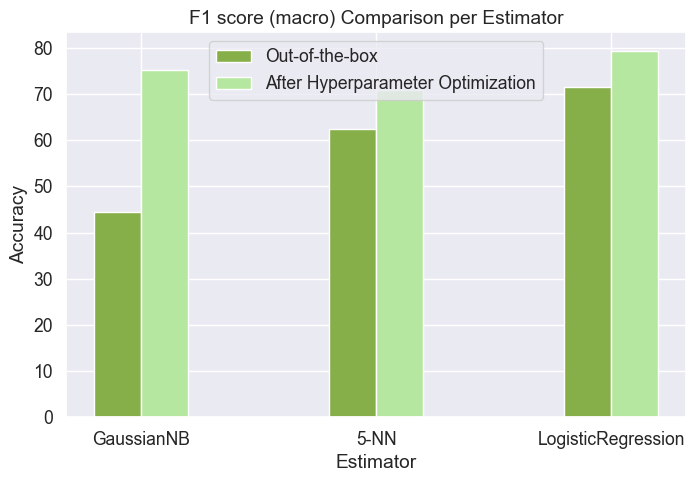

In [187]:
optimal_f1s = [np.round(i[0]['f1-score']*100, 3) for i in evaluations2[1:]]
plot_comparison(optimal_f1s, f1s, title='F1 score (macro) Comparison per Estimator')

Τέλος, για τον καλύτερο και τον χειρότερο ταξινομητή (εξαιρουμένων των dummy) ως προς την ορθότητα εκτυπώνουμε τους πίνακες σύγχυσης (**confusion matrices**) με γραφικό τρόπο:

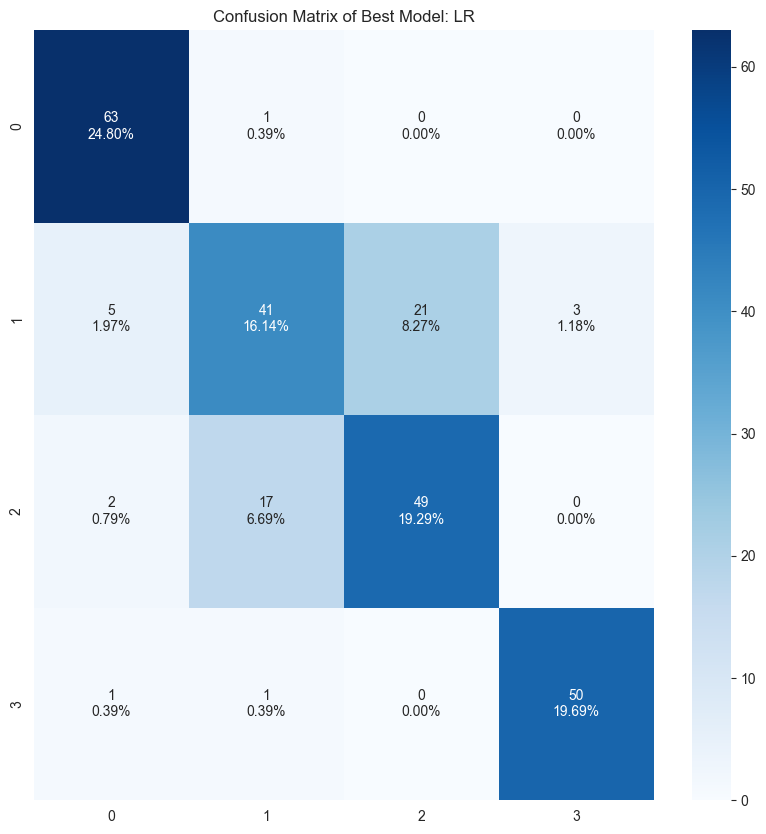

In [123]:
show_confusion_matrix(best_lr_acc, X_test, y_test, 'Confusion Matrix of Best Model: LR')

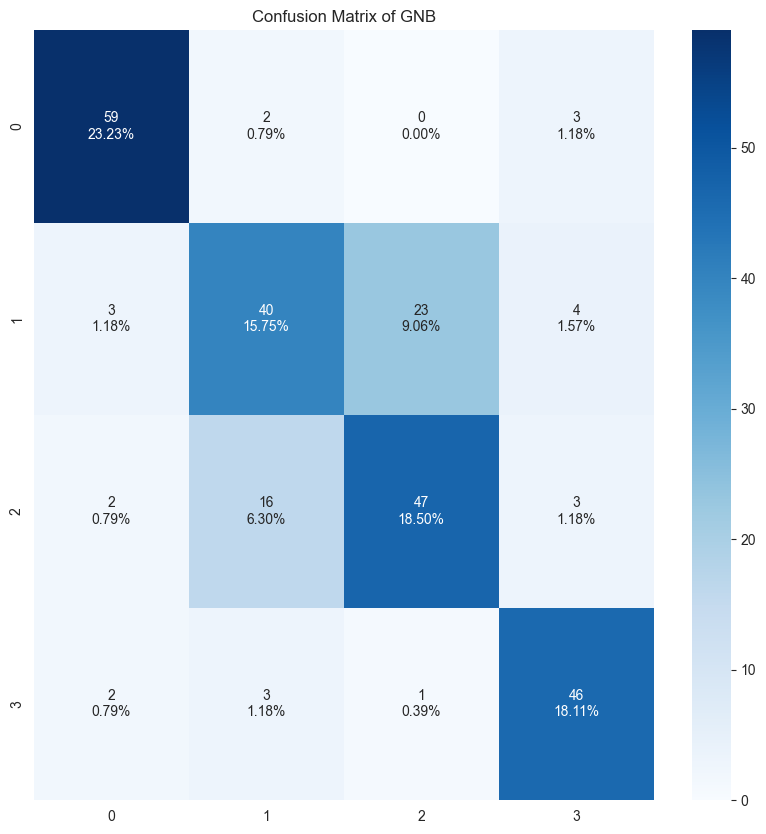

In [142]:
show_confusion_matrix(best_nb_acc, X_test, y_test, 'Confusion Matrix of GNB')

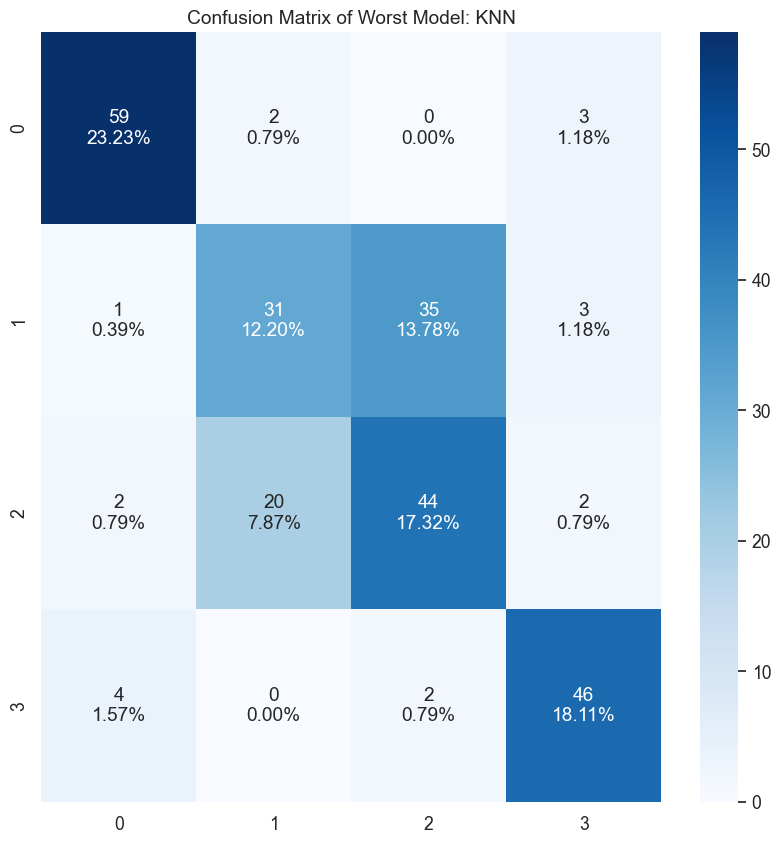

In [168]:
show_confusion_matrix(best_knn_acc, X_test, y_test, 'Confusion Matrix of Worst Model: KNN')

In [144]:
class_mapping

{'bus': 0, 'opel': 1, 'saab': 2, 'van': 3}

Γνωρίζουμε ότι ο πίνακας σύχγυσης $C$ είναι τέτοιος ώστε το $C_{i, j}$ είναι ίσο με τα δείγματα που ενώ ανήκουν στην κατηγορία $i$ ταξινομήθηκαν στην κατηγορία  $j$.
Παρατηρούμε ότι σε όλα τα μοντέλα (και στο χειρότερο και στο καλύτερο) έχουμε υψηλή τιμή $C_{1,2}$ και ακολούθως $C_{2,1}$ ενώ για όλα τα υπόλοιπα i, j ($i != j$) οι τιμές στον πίνακα σύγχυσης είναι αρκετά μικρές (< 5). Αυτό σημαίνει ότι και όλοι οι ταξινομητές μπερδεύουν τα οχήματα κατηγορίας 1 (δηλαδή opel) περνώντας το λανθασμένα για όχημα κατηγορίας 2 (δηλαδή saab) και το ανάποδο. Αυτές οι δύο μάρκες φαίνεται να φτιάχνουν **αυτοκίνητα** που μοιάζουν μορφολογικά και σίγουρα είναι αρκετά διαφορετικά από τα bus και van. Τα μοντέλα φαίνεται να κάνουν κάποια μπερδέματα μεταξύ bus & van αλλά είναι σημαντικά λιγότερα.
Τελικώς, στο εν λόγω πρόβλημα κατηγοριοποίησης θα χρησιμοποιούσαμε έναν **Logistic Regression Classifier**, καθώς όχι μόνο δίνει τα καλύτερα αποτελέσματα και στις δύο μετρικές (accuracy & F1), αλλά επίσης έχει σχετικά μικρούς χρόνους εκτέλεσης τόσο για train όσο και για inference. Όπως αναφέρθηκε παραπάνω, η υπεροχή του LR οφείλεται κυρίως στο γεγονός ότι πρόκειται για ένα πρόβλημα που μπορεί να θεωρηθεί γραμμικά διαχωρήσιμο, ενώ τα features των δειγμάτων δεν είναι "ικανοποιητικά" ανεξάρτητα μεταξύ τους, ώστε να προτιμηθεί ο NB.